In [37]:
import numpy as np
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt
import helpers as hp
import stationary as st
import plotresults as pr
import panelvar as pvar
import deepvar
import var
import lstm
import warnings 
import irf

warnings.filterwarnings('ignore', category=UserWarning, module='statsmodels')
warnings.filterwarnings('ignore', message='X does not have valid feature names, but StandardScaler was fitted with feature names')
warnings.filterwarnings('ignore', message='An unsupported index was provided and will be ignored when e.g. forecasting.')

In [38]:
def prepare_df(df):
    df['log_GDP'] = np.log(df['GDP']) 
    df['log_CPI'] = np.log(df['CPI']) 
    final_df = df.copy()
    final_df['TIME_PERIOD'] = pd.to_datetime(final_df['TIME_PERIOD'])
    final_df = final_df.set_index(["Country", "TIME_PERIOD"])
    final_df = final_df.drop(columns = {"Code", "GDP", 'CPI'})
    return final_df



Basic VAR detrend results

In [39]:
df = pd.read_csv('./Data/WithoutPolicyRate.csv')

variables_to_keep = ['log_GDP', 'household_debt', 'private_debt']

In [40]:
df = prepare_df(df)
# pr_df = prepare_df(pr_df)
df = df.drop(columns = {"exchange_rate"})
df = df[variables_to_keep]
LAGS = 3


In [41]:
variables = df.columns
final_detrend = st.detrend_data(df, variables, 1) 
final_detrend = final_detrend[final_detrend.index.get_level_values("TIME_PERIOD")< "2020-03-31"]

Index(['Colombia', 'Netherlands, The', 'United Kingdom', 'India', 'Israel',
       'Sweden', 'Thailand', 'Australia', 'New Zealand', 'Ireland', 'Germany',
       'Brazil', 'Mexico', 'Greece', 'Norway', 'Austria', 'Italy', 'Argentina',
       'Singapore', 'France', 'Portugal', 'Hungary', 'Spain', 'Canada',
       'Switzerland', 'United States', 'Denmark', 'Indonesia',
       'China, P.R.: Hong Kong', 'Luxembourg', 'Japan', 'Finland',
       'South Africa', 'Chile', 'Czech Rep.', 'Poland, Rep. of',
       'Türkiye, Rep of', 'Korea, Rep. of', 'Belgium'],
      dtype='object', name='Country')


In [42]:
aic_lags = var.aic_test(final_detrend)

lag_range = range(min(aic_lags),max(aic_lags)+1)
lag_list = [x for x in lag_range]

In [43]:
train_dt_var, test_dt_var = hp.time_panel_split_predict(final_detrend)

lstm_df= lstm.create_lstm_data(final_detrend, LAGS)

inputs = lstm.get_lstm_input(final_detrend, LAGS)
lstm_train, lstm_val, lstm_test= lstm.train_val_test_split(lstm_df)

lstm_df_window = lstm.create_lstm_data(final_detrend, 1)
inputs_window = lstm.get_lstm_input(final_detrend, 1)
lstm_train_window, lstm_val_window, lstm_test_window= lstm.train_val_test_split(lstm_df_window)


In [44]:
num_unique_countries = len(final_detrend.index.get_level_values("Country").unique())
print("Countries", num_unique_countries)
print("Number of obsevations", len(final_detrend))

Countries 39
Number of obsevations 4065


In [45]:
import lstm
t, v, te = lstm.train_val_test_split(lstm_df, .85)
countries = t.index.get_level_values('Country').unique()
min_len = float('inf')
shortest_country = None

for country in countries:
    country_len = len(hp.get_country(v, country))
    if country_len < min_len:
        min_len = country_len
        shortest_country = country
min_len


6

In [46]:
def lstm_error_comparison(df, df_window, inputs_window, target, lag_range=(1, 8), min_lr=1e-4, max_lr=1e-1, num_epochs=500):
   
    num_elements = lag_range[1] - lag_range[0]
    
    errors = {
        "window_mse": ["" for _ in range(num_elements)],
        "no_window_mse": ["" for _ in range(num_elements)],
        "window_rmse": ["" for _ in range(num_elements)],
        "no_window_rmse": ["" for _ in range(num_elements)],
        "window_mae": ["" for _ in range(num_elements)],
        "no_window_mae": ["" for _ in range(num_elements)]
    }
    
    index_labels = [f"{i}" for i in range(lag_range[0], lag_range[1])]
    
    errors_df = pd.DataFrame(errors, index=index_labels)
    
    # Loop through each lag
    for lag in range(lag_range[0], lag_range[1]):
        lstm_df = lstm.create_lstm_data(df, lag)
        inputs = lstm.get_lstm_input(df, lag)
        best_lr = lstm.find_learning_rate(lstm_df, inputs, target, min_lr=min_lr, max_lr=max_lr)
        model, predictions, metrics, scaler_X, scaler_y = lstm.train_lstm_model(lstm_df, inputs, [target], best_lr, num_epochs=num_epochs)
        best_lr_window = lstm.find_learning_rate(df_window, inputs_window, target, min_lr=min_lr, max_lr=max_lr)
        model_window, predictions_window, metrics_window, scaler_X_window, scaler_y_window = lstm.train_lstm_model_windows(
            df_window, inputs_window, [target], learning_rate=best_lr_window, num_epochs=num_epochs, windows=lag
        )
        
        errors_df.loc[f"{lag}", "no_window_mse"] = metrics[0]
        errors_df.loc[f"{lag}", "no_window_rmse"] = metrics[1]
        errors_df.loc[f"{lag}", "no_window_mae"] = metrics[2]
        errors_df.loc[f"{lag}", "window_mse"] = metrics_window[0]
        errors_df.loc[f"{lag}", "window_rmse"] = metrics_window[1]
        errors_df.loc[f"{lag}", "window_mae"] = metrics_window[2]
        
    return errors_df


def plot_comparison(df, metrics=['mse', 'rmse', 'mae'], 
                   titles=['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Error (MAE)'],
                   figsize=(12, 15), 
                   window_color='#3498db', no_window_color='#e74c3c'):

    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    plt.style.use('seaborn-v0_8-whitegrid')
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['axes.titlesize'] = 14
    mpl.rcParams['axes.labelsize'] = 13
    
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True, facecolor='#f9f9f9')
    fig.suptitle('Comparison of Error Metrics With and Without Window', fontsize=16, y=0.98)
    
    #loop through each metric
    for i, metric in enumerate(metrics):
        window_col = f'window_{metric}'
        no_window_col = f'no_window_{metric}'
        
        x = np.arange(len(df.index))
        width = 0.35
        
        bars1 = axes[i].bar(x - width/2, df[window_col], width,
                         label='With Window', color=window_color, alpha=0.8,
                         edgecolor='white', linewidth=0.7)
        
        bars2 = axes[i].bar(x + width/2, df[no_window_col], width,
                          label='No Window', color=no_window_color, alpha=0.8,
                          edgecolor='white', linewidth=0.7)
        
        def add_labels(bars):
            for bar in bars:
                height = bar.get_height()
                axes[i].annotate(f'{height:.2f}',
                                xy=(bar.get_x() + bar.get_width() / 2, height),
                                xytext=(0, 3),  
                                textcoords="offset points",
                                ha='center', va='bottom', fontsize=10)
        
        add_labels(bars1)
        add_labels(bars2)
        
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(df.index)
        axes[i].set_title(titles[i], pad=15, fontweight='bold')
        axes[i].set_ylabel(metric.upper(), fontweight='bold')
        axes[i].grid(True, linestyle='--', alpha=0.3, axis='y')
        axes[i].set_facecolor('#f5f5f5')
        axes[i].legend(frameon=True, fancybox=True, shadow=True, loc='upper right')
        
        
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
    
    
    axes[2].set_xlabel('Test Case', fontweight='bold')
    
    plt.tight_layout(pad=3)
    plt.subplots_adjust(top=0.94)  
    plt.show()


## Get Metrics for Log_GDP


Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Finding optimal learning rate...


Finding best initial lr:  31%|███       | 31/100 [00:00<00:00, 113.31it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 106.73it/s]
Learning rate set to 0.00034673685045253164
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_5fad936d-43b9-4047-a94f-db9c9aa9c772.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_5fad936d-43b9-4047-a94f-db9c9aa9c772.ckpt


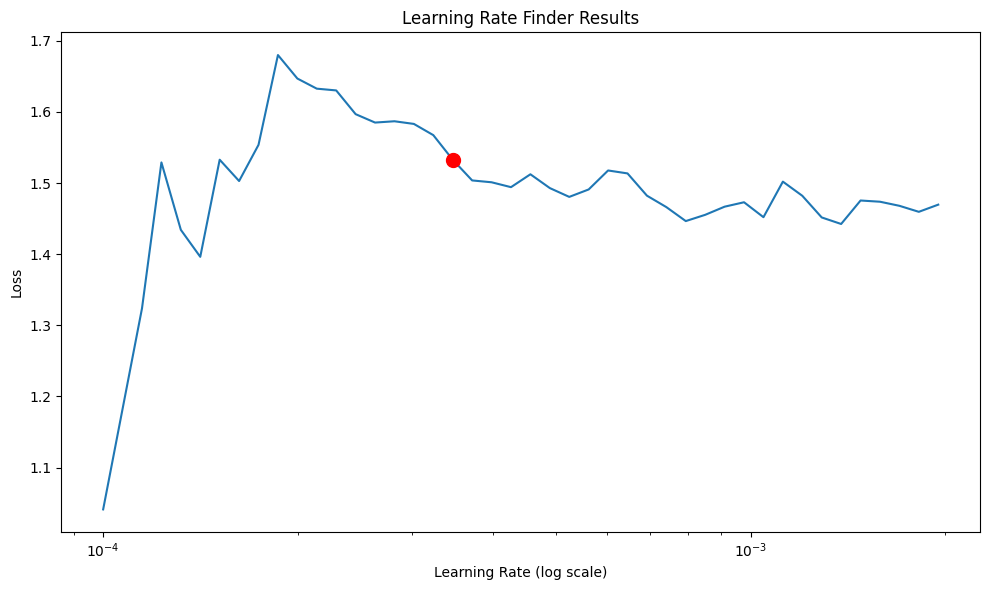

Seed set to 18
Seed set to 18
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than

Suggested learning rate: 0.00034674


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

NameError: name 'exit' is not defined

In [47]:
lGDP_errors_df = lstm_error_comparison(final_detrend, lstm_df_window, inputs_window, 'log_GDP', lag_range=(1, 7), min_lr=1e-4, max_lr=1e-1, num_epochs=500, verbose=False)



## Get Metrics for Household Debt

In [12]:
# hhd_errors_df = lstm_error_comparison(final_detrend, lstm_df_window, inputs_window, 'household_debt', lag_range=(1, 7), min_lr=1e-4, max_lr=1e-1, num_epochs=500)


## Get Metrics for Private Debt

In [34]:
# private_debt_errors_df = lstm_error_comparison(final_detrend, lstm_df_window, inputs_window, 'private_debt', lag_range=(1, 7), min_lr=1e-4, max_lr=1e-1, num_epochs=500)
len(countries)

39

In [ ]:

plot_comparison(lGDP_errors_df)

NameError: name 'lGDP_errors_df' is not defined

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps

Finding optimal learning rate...


Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 133.84it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 130.13it/s]
Learning rate set to 0.00016595869074375607
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_a8076340-4730-4726-ae76-5922ba39fc7a.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_a8076340-4730-4726-ae76-5922ba39fc7a.ckpt


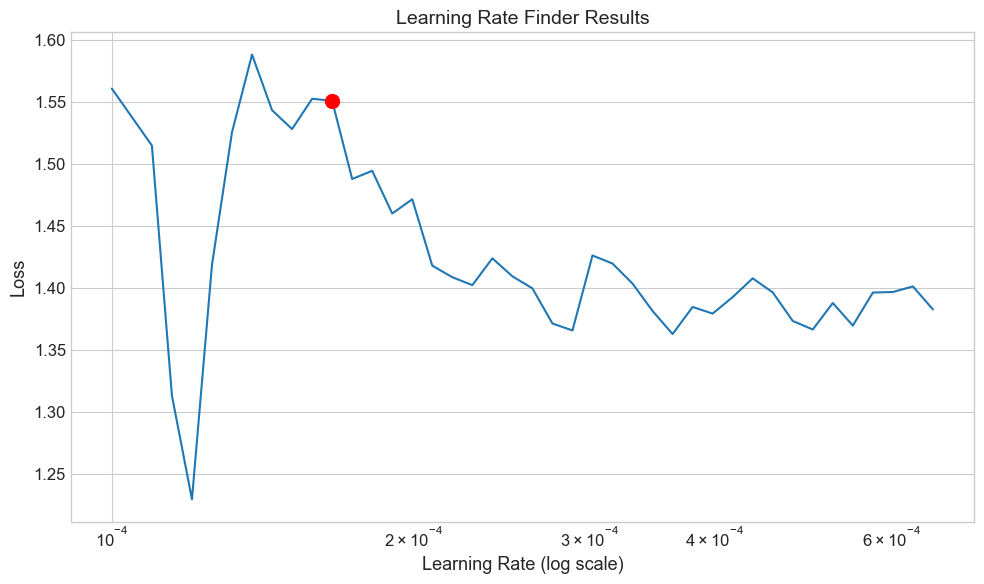

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00016596
Finding optimal learning rate...


Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 129.94it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 127.25it/s]
Learning rate set to 0.00022908676527677731
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_d0977f4b-69d4-4775-a359-285cb060ae09.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_d0977f4b-69d4-4775-a359-285cb060ae09.ckpt


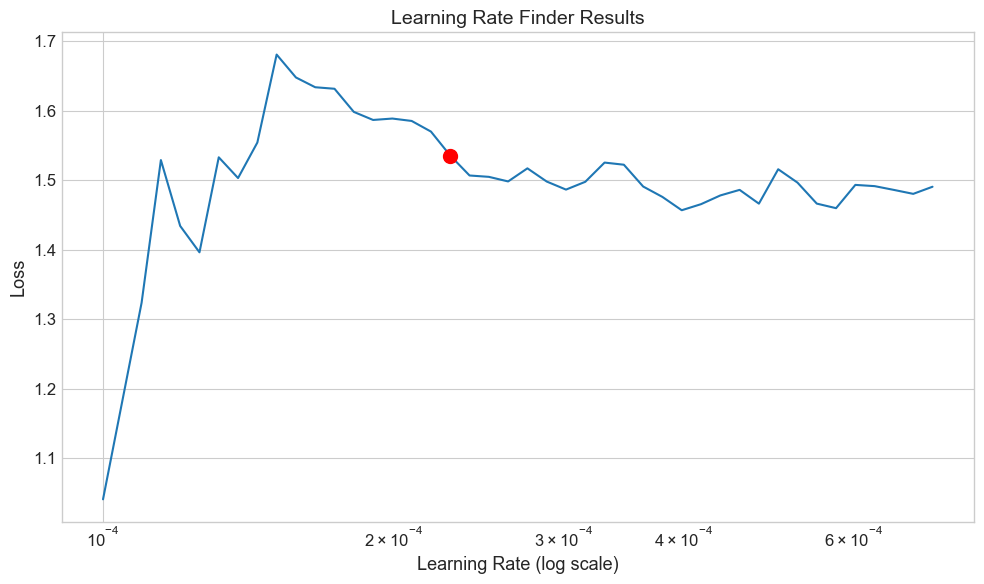

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00022909
Finding optimal learning rate...


Finding best initial lr:  34%|███▍      | 34/100 [00:00<00:00, 113.85it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 108.39it/s]
Learning rate set to 0.0006309573444801934
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_2d681ea0-d99d-4aa7-8c9a-b203e22102ec.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_2d681ea0-d99d-4aa7-8c9a-b203e22102ec.ckpt


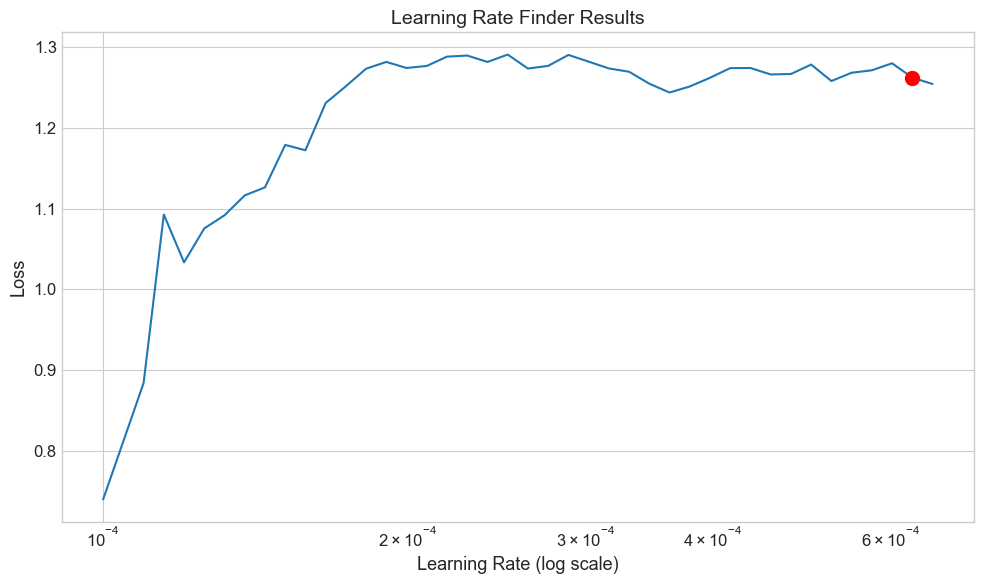

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00063096
Finding optimal learning rate...


Finding best initial lr:  39%|███▉      | 39/100 [00:00<00:00, 128.82it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 123.19it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_35103a62-e673-4530-a243-d7ecc5cb9c2d.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_35103a62-e673-4530-a243-d7ecc5cb9c2d.ckpt


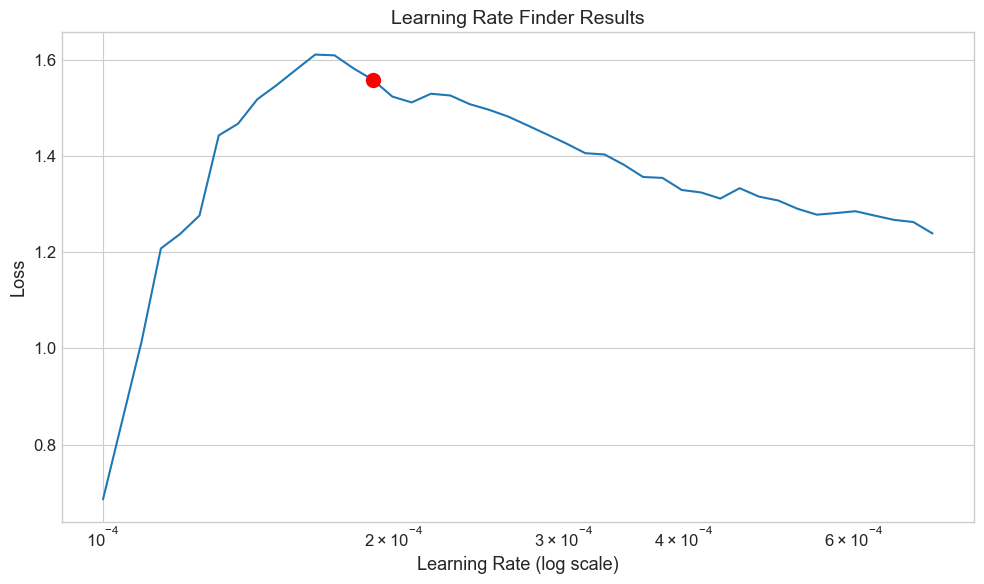

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00019055
Finding optimal learning rate...


Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 136.22it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 134.23it/s]
Learning rate set to 0.0006309573444801934
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_f0129384-d65b-4523-9197-5a5665c26dba.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_f0129384-d65b-4523-9197-5a5665c26dba.ckpt


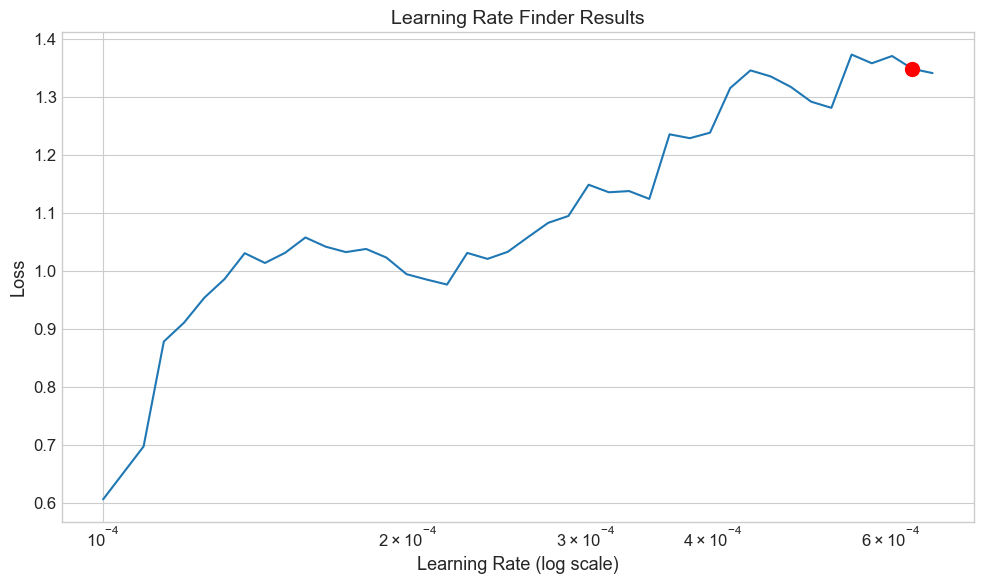

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00063096
Finding optimal learning rate...


Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 130.25it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 128.84it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_66b4e61d-c193-4137-aa34-a1e562b68930.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_66b4e61d-c193-4137-aa34-a1e562b68930.ckpt


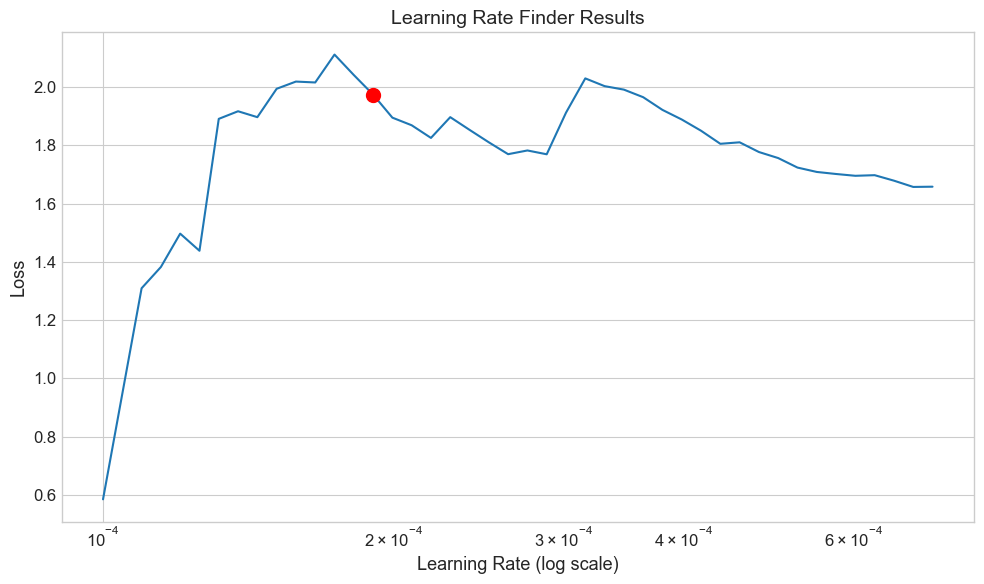

Suggested learning rate: 0.00019055
Non-windowed parameters: {'log_GDP': {'learning_rate': 0.00016595869074375607, 'epochs': 500}, 'household_debt': {'learning_rate': 0.0006309573444801934, 'epochs': 500}, 'private_debt': {'learning_rate': 0.0006309573444801934, 'epochs': 500}}
Windowed parameters: {'log_GDP': {'learning_rate': 0.00022908676527677731, 'epochs': 500}, 'household_debt': {'learning_rate': 0.00019054607179632473, 'epochs': 500}, 'private_debt': {'learning_rate': 0.00019054607179632473, 'epochs': 500}}


In [16]:
variables = final_detrend.columns
param_dict_window = {}
param_dict_no_window = {}


LAGS = 3
lstm_df= lstm.create_lstm_data(final_detrend, LAGS)

min_lr = 0.0001  
max_lr = 0.01    

for variable in variables:
    best_lr = lstm.find_learning_rate(lstm_df, inputs, f'{variable}', min_lr=min_lr, max_lr=max_lr)
    param_dict_no_window[variable] = {'learning_rate': best_lr, 'epochs': 500}
    best_lr_window = lstm.find_learning_rate(lstm_df_window, inputs_window, f'{variable}', min_lr=min_lr, max_lr=max_lr)
    param_dict_window[variable] = {'learning_rate': best_lr_window, 'epochs': 500}

model_scaler_dict_no_window = deepvar.get_model_and_scaler_no_window(lstm_df, variables, inputs, param_dict_no_window)
model_scaler_dict_window = deepvar.get_model_and_scaler_window(lstm_df_window, variables, inputs_window, param_dict_window, lags=LAGS)


gdp_deepvar_metrics_no_window = deepvar.test_errors(lstm_df, lstm_test, 'log_GDP', model_scaler_dict_no_window, variables, LAGS)
hhd_deepvar_metrics_no_window = deepvar.test_errors(lstm_df, lstm_test,  'household_debt', model_scaler_dict_no_window, variables, LAGS)
fd_deepvar_metrics_no_window = deepvar.test_errors(lstm_df, lstm_test,  'private_debt', model_scaler_dict_no_window, variables, LAGS)


# For the windowed version the lag is always 1 because the window the length of the lag is created model_scaler_dict_window
gdp_deepvar_metrics_windows = deepvar.test_errors(lstm_df_window, lstm_test_window, 'log_GDP', model_scaler_dict_window, variables, 1)
hhd_deepvar_metrics_windows  = deepvar.test_errors(lstm_df_window, lstm_test_window,  'household_debt', model_scaler_dict_window, variables, 1)
fd_deepvar_metrics_windows  = deepvar.test_errors(lstm_df_window, lstm_test_window,  'private_debt', model_scaler_dict_window,variables, 1)



In [17]:
model_scaler_dict_no_window = deepvar.get_model_and_scaler_no_window(lstm_df, variables, inputs, param_dict_no_window)
model_scaler_dict_window = deepvar.get_model_and_scaler_window(lstm_df_window, variables, inputs_window, param_dict_window, 3)

Seed set to 18
Seed set to 18
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Processing lag: 1
  Finding learning rate for log_GDP
Finding optimal learning rate...


Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 132.59it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 129.02it/s]
Learning rate set to 0.00022908676527677731
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_ee03f6a9-eb1b-4a43-a972-0e82189f2f2b.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_ee03f6a9-eb1b-4a43-a972-0e82189f2f2b.ckpt


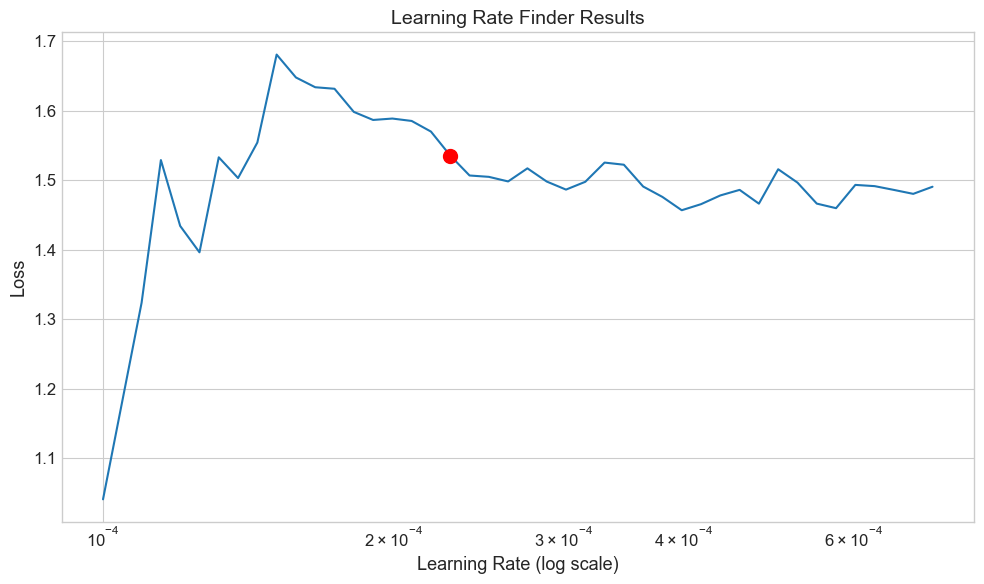

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00022909
Finding optimal learning rate...


Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 135.48it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 133.89it/s]
Learning rate set to 0.00022908676527677731
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_cdd755a3-2765-4620-b63b-c7d7769e7bb7.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_cdd755a3-2765-4620-b63b-c7d7769e7bb7.ckpt


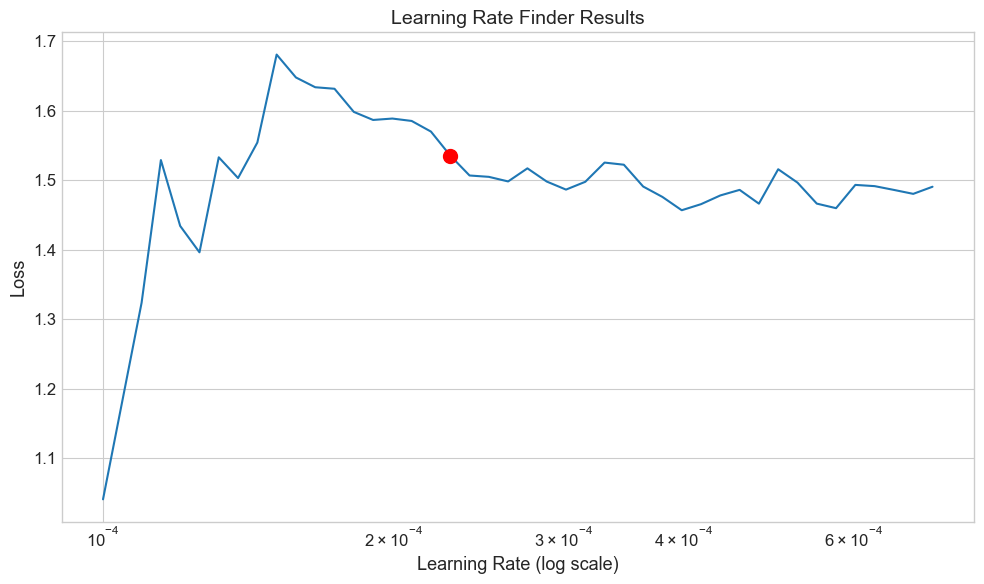

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00022909
  Finding learning rate for household_debt
Finding optimal learning rate...


Finding best initial lr:  42%|████▏     | 42/100 [00:00<00:00, 136.04it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 133.31it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_6adf5e74-8e8a-44a2-8829-8e9844a72a3d.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_6adf5e74-8e8a-44a2-8829-8e9844a72a3d.ckpt


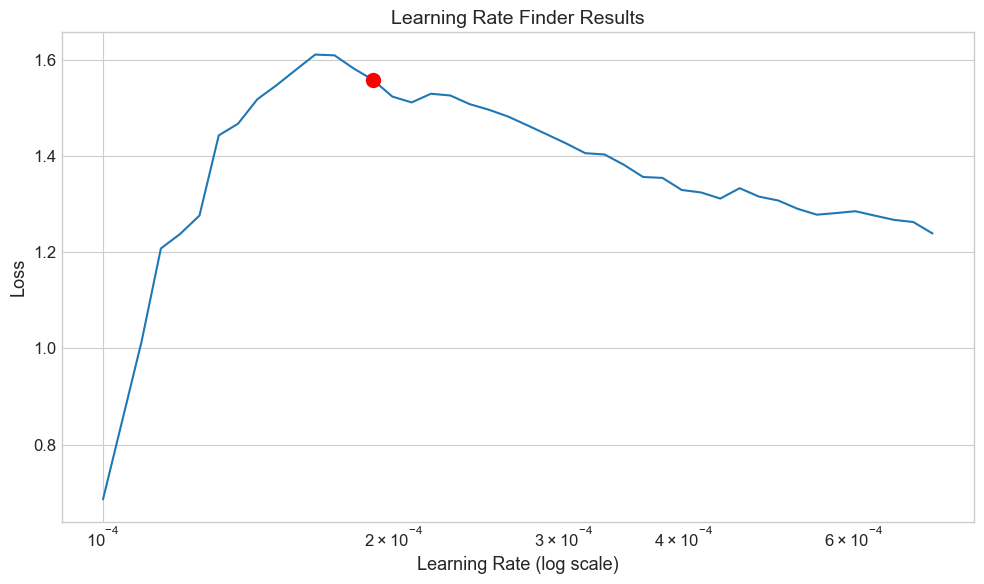

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00019055
Finding optimal learning rate...


Finding best initial lr:  42%|████▏     | 42/100 [00:00<00:00, 135.83it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 133.64it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_3fccdab2-e9b3-4be1-89d1-2d746f987e8c.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_3fccdab2-e9b3-4be1-89d1-2d746f987e8c.ckpt


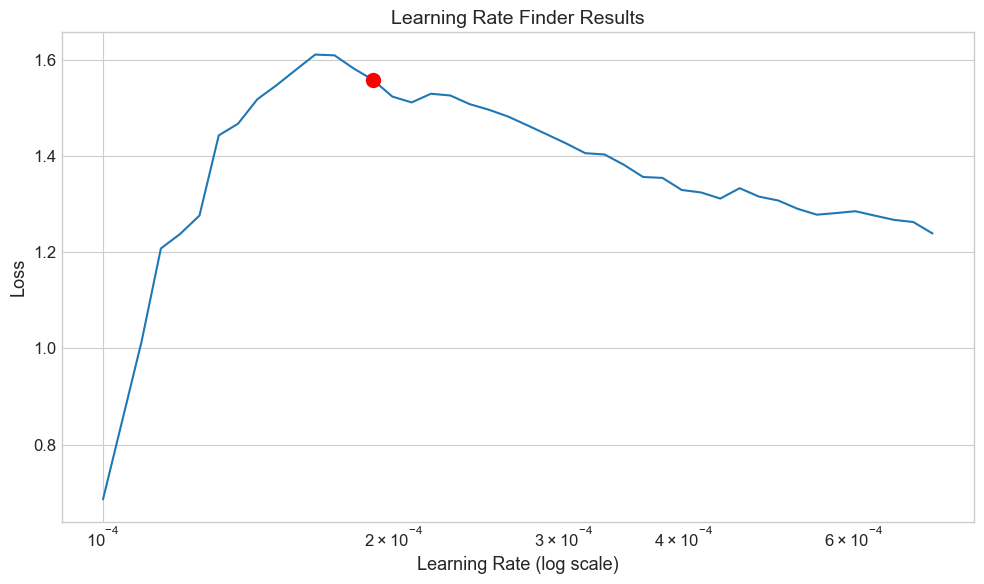

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00019055
  Finding learning rate for private_debt
Finding optimal learning rate...


Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 141.07it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 138.85it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_ed363122-d303-47f1-9d94-4bb9d210b3f1.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_ed363122-d303-47f1-9d94-4bb9d210b3f1.ckpt


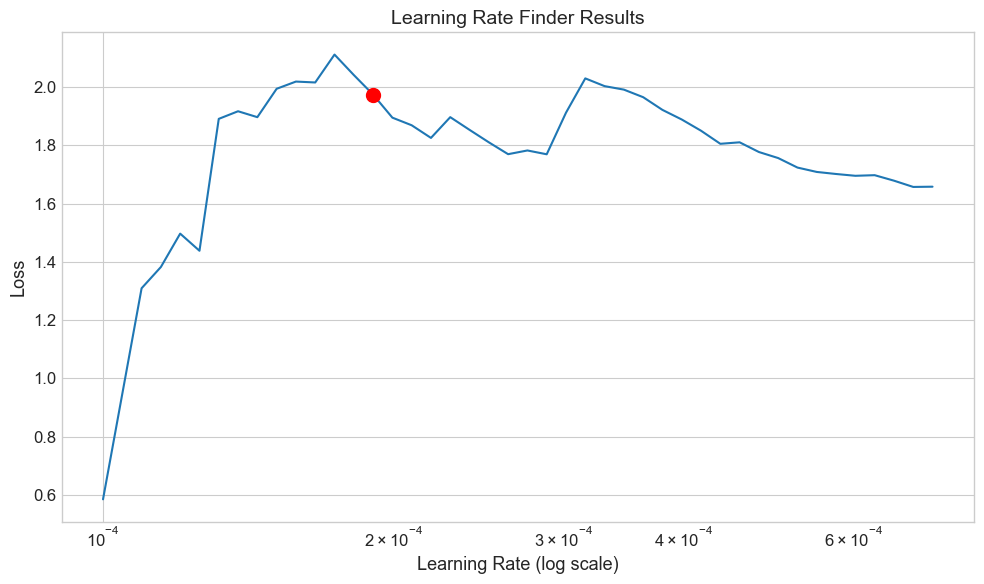

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00019055
Finding optimal learning rate...


Finding best initial lr:  42%|████▏     | 42/100 [00:00<00:00, 135.83it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 134.41it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_d860d96c-ce9c-4d34-b1e2-ff3481df3492.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_d860d96c-ce9c-4d34-b1e2-ff3481df3492.ckpt


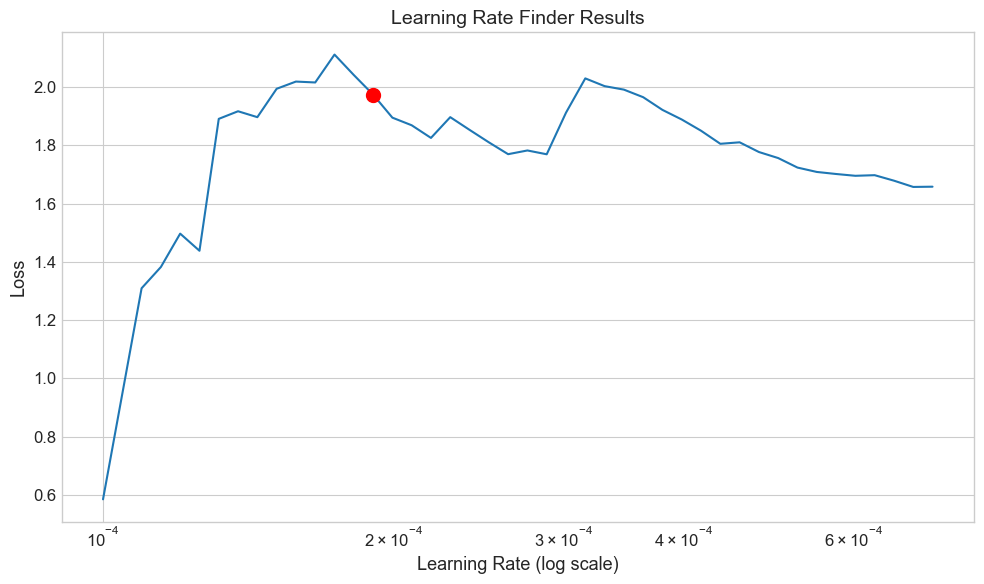

Seed set to 18
Seed set to 18
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than

Suggested learning rate: 0.00019055


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

  Computing metrics for log_GDP


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

  Computing metrics for household_debt


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

  Computing metrics for private_debt


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

Processing lag: 2
  Finding learning rate for log_GDP
Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 133.81it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 42 steps due to diverging loss.
Finding best initial lr:  42%|████▏     | 42/100 [00:00<00:00, 129.50it/s]
Learning rate set to 0.0005248074602497726
Restoring states from the checkpoint path at 

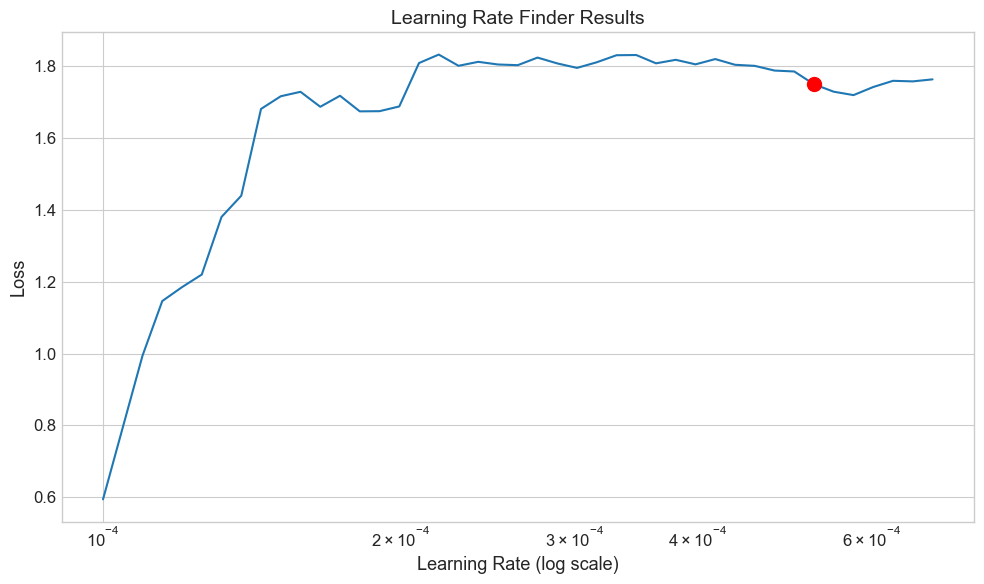

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00052481
Finding optimal learning rate...


Finding best initial lr:  30%|███       | 30/100 [00:00<00:00, 145.59it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 144.89it/s]
Learning rate set to 0.00022908676527677731
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_91cb7912-e0a4-4774-9467-39af35cd5da8.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_91cb7912-e0a4-4774-9467-39af35cd5da8.ckpt


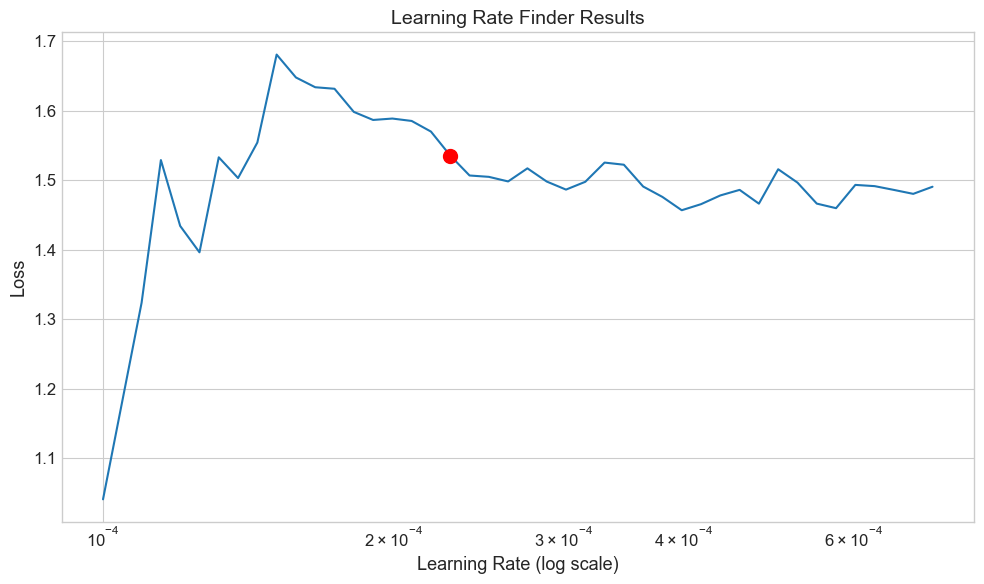

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00022909
  Finding learning rate for household_debt
Finding optimal learning rate...


Finding best initial lr:  29%|██▉       | 29/100 [00:00<00:00, 138.87it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 42 steps due to diverging loss.
Finding best initial lr:  42%|████▏     | 42/100 [00:00<00:00, 138.76it/s]
Learning rate set to 0.0002630267991895382
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_2f505fa2-b9d7-47e6-b246-61b9be08f4c1.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_2f505fa2-b9d7-47e6-b246-61b9be08f4c1.ckpt


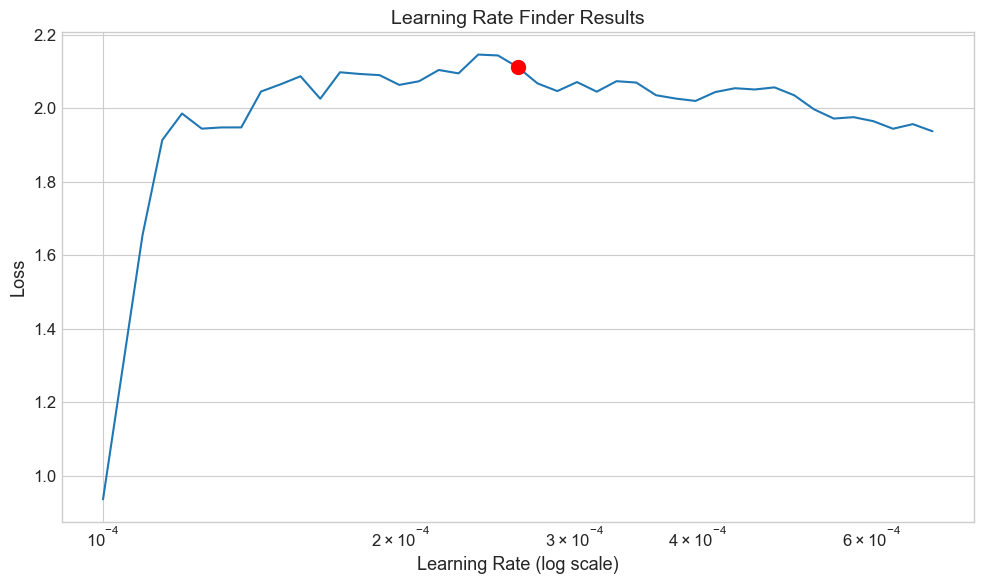

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00026303
Finding optimal learning rate...


Finding best initial lr:  42%|████▏     | 42/100 [00:00<00:00, 134.97it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 134.25it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_bddcfc8b-9c9d-4ff0-8bb5-7f2f1723e417.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_bddcfc8b-9c9d-4ff0-8bb5-7f2f1723e417.ckpt


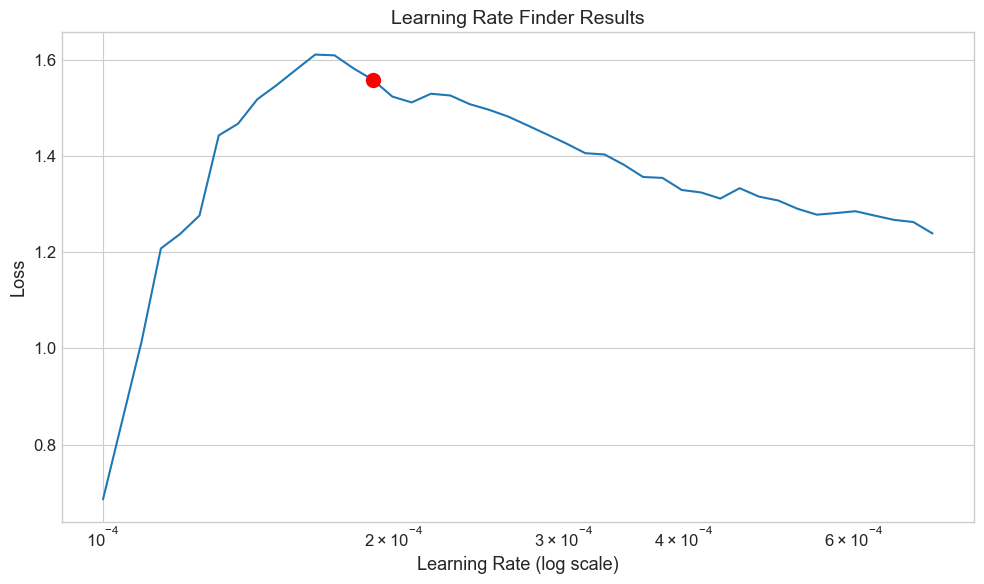

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00019055
  Finding learning rate for private_debt
Finding optimal learning rate...


Finding best initial lr:  29%|██▉       | 29/100 [00:00<00:00, 140.24it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 42 steps due to diverging loss.
Finding best initial lr:  42%|████▏     | 42/100 [00:00<00:00, 141.77it/s]
Learning rate set to 0.00019952623149688796
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_d061a490-e238-4799-b01c-7b835a39b565.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_d061a490-e238-4799-b01c-7b835a39b565.ckpt


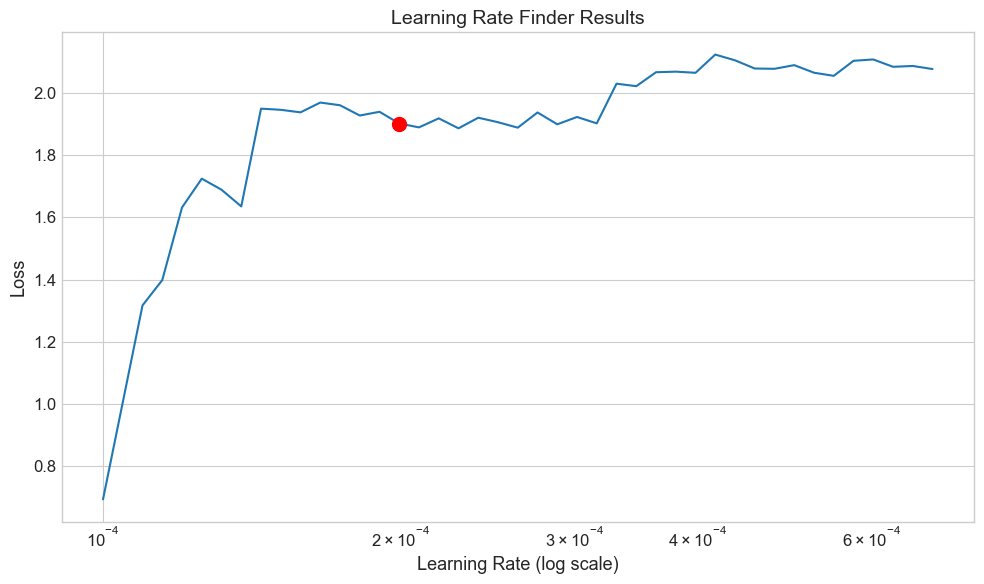

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00019953
Finding optimal learning rate...


Finding best initial lr:  29%|██▉       | 29/100 [00:00<00:00, 142.59it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 143.66it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_7cfd9c8b-1494-4663-b73f-c605174862f0.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_7cfd9c8b-1494-4663-b73f-c605174862f0.ckpt


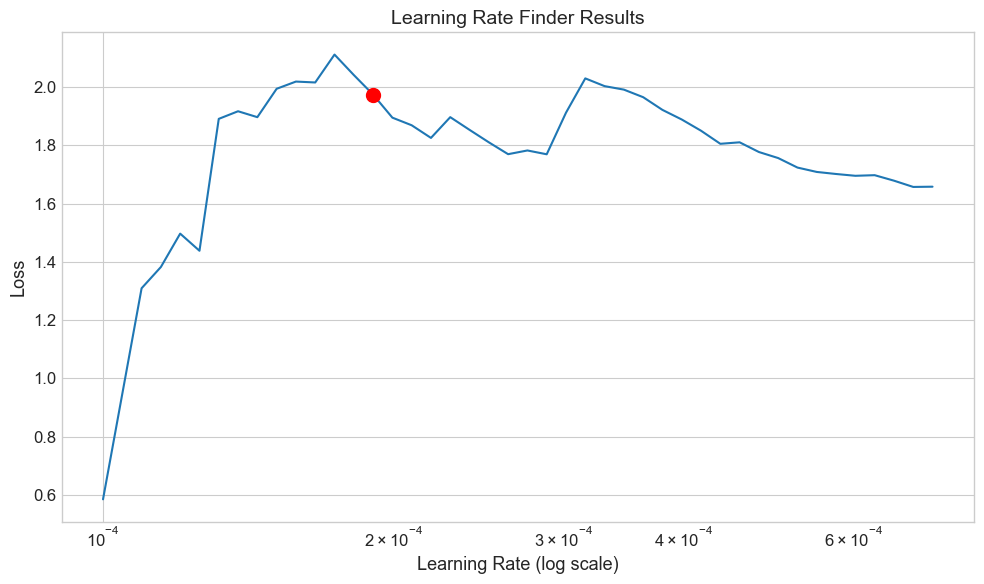

Seed set to 18
Seed set to 18
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than

Suggested learning rate: 0.00019055


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

  Computing metrics for log_GDP


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

  Computing metrics for household_debt


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

  Computing metrics for private_debt


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

Processing lag: 3
  Finding learning rate for log_GDP
Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr:  26%|██▌       | 26/100 [00:00<00:00, 130.50it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 133.35it/s]
Learning rate set to 0.00016595869074375607
Restoring states from the checkpoint path at

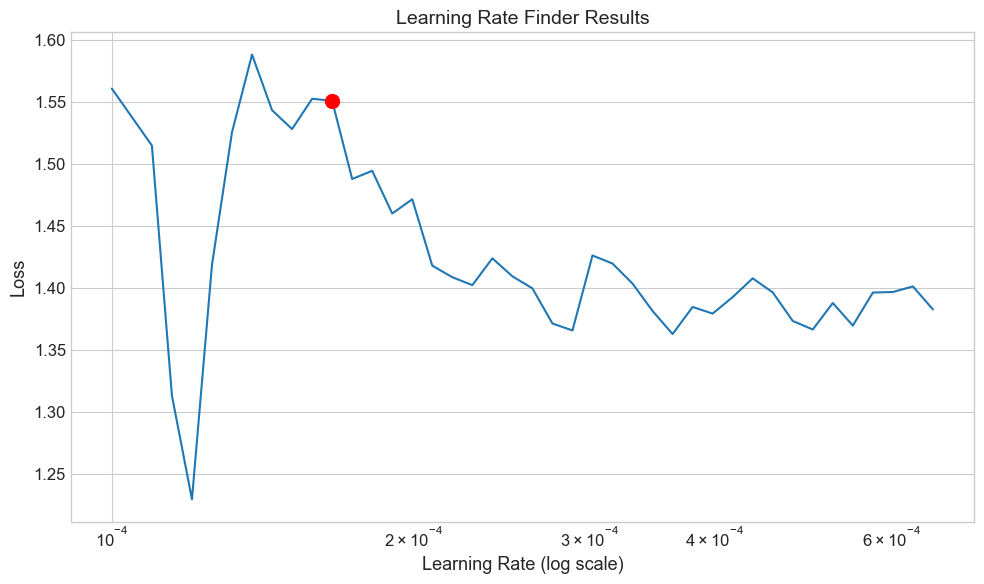

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00016596
Finding optimal learning rate...


Finding best initial lr:  31%|███       | 31/100 [00:00<00:00, 150.51it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 149.83it/s]
Learning rate set to 0.00022908676527677731
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_a2a628e5-299b-4d30-8eaa-527d26b85e6c.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_a2a628e5-299b-4d30-8eaa-527d26b85e6c.ckpt


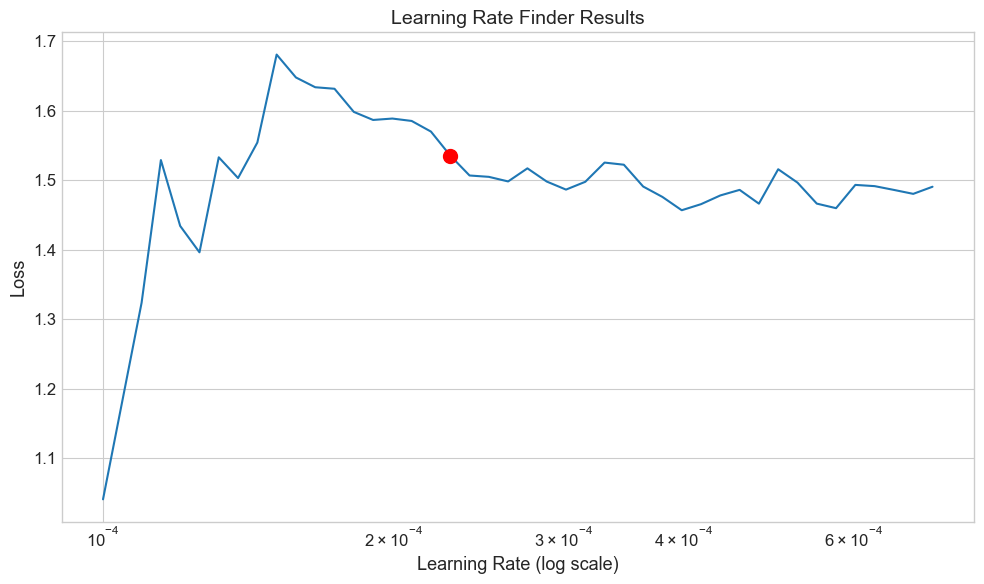

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00022909
  Finding learning rate for household_debt
Finding optimal learning rate...


Finding best initial lr:  32%|███▏      | 32/100 [00:00<00:00, 151.67it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 151.05it/s]
Learning rate set to 0.0006309573444801934
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_144063ff-3feb-45a3-a193-79cc618d0c1f.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_144063ff-3feb-45a3-a193-79cc618d0c1f.ckpt


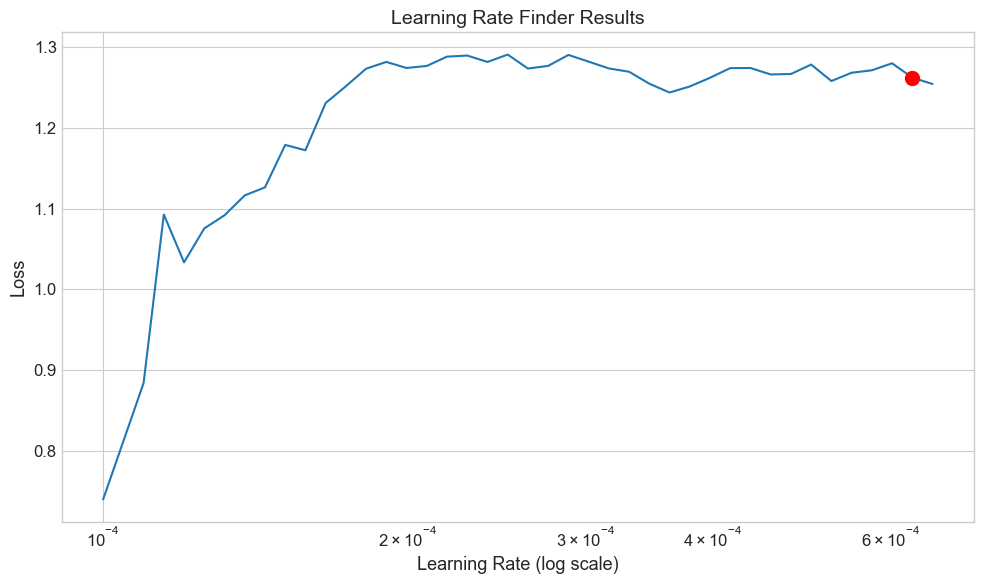

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00063096
Finding optimal learning rate...


Finding best initial lr:  31%|███       | 31/100 [00:00<00:00, 149.66it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 149.58it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_fb98b5bd-fd4d-41df-847d-1794d6af2711.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_fb98b5bd-fd4d-41df-847d-1794d6af2711.ckpt


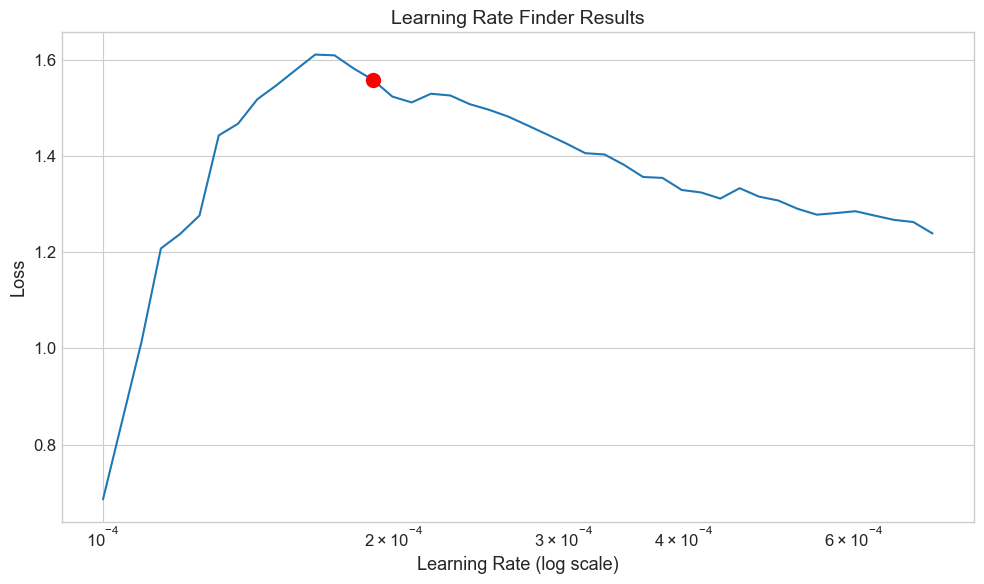

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00019055
  Finding learning rate for private_debt
Finding optimal learning rate...


Finding best initial lr:  31%|███       | 31/100 [00:00<00:00, 150.10it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 149.31it/s]
Learning rate set to 0.0006309573444801934
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_1a10547a-dfa8-488b-986b-c4888cda29d7.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_1a10547a-dfa8-488b-986b-c4888cda29d7.ckpt


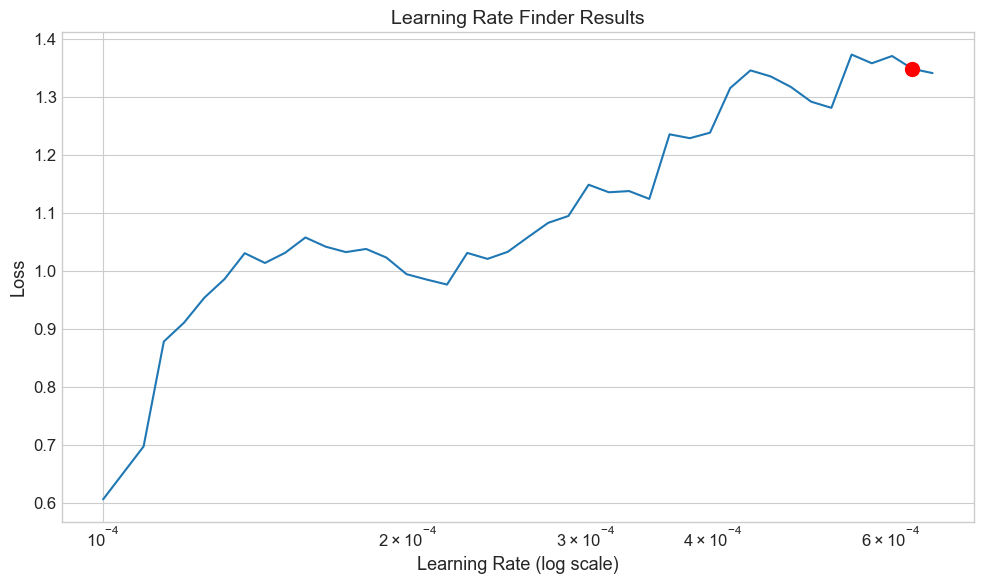

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00063096
Finding optimal learning rate...


Finding best initial lr:  29%|██▉       | 29/100 [00:00<00:00, 143.25it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 144.17it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_73c71fc9-ff6b-4c2b-bacc-473bc05f1549.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_73c71fc9-ff6b-4c2b-bacc-473bc05f1549.ckpt


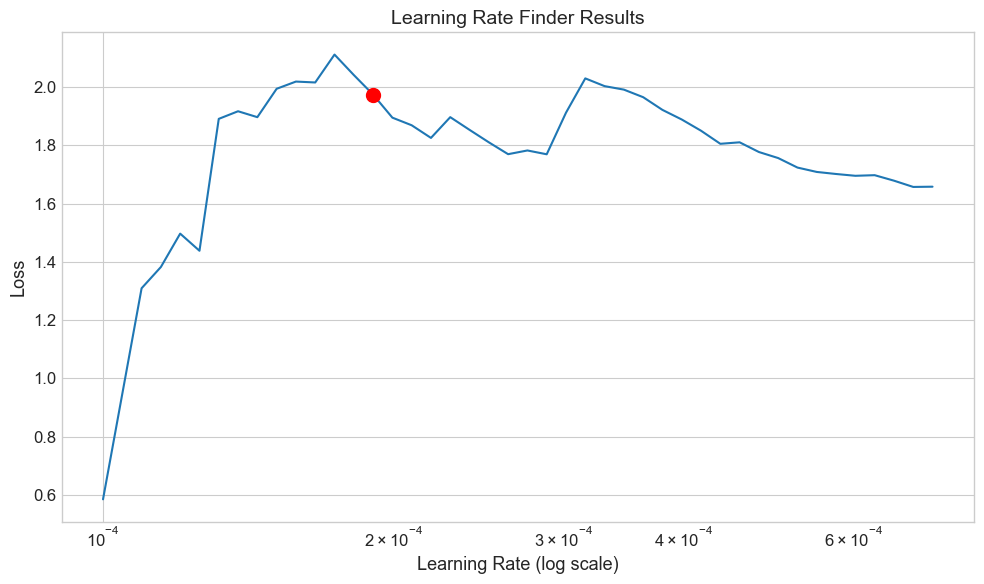

Seed set to 18
Seed set to 18
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than

Suggested learning rate: 0.00019055


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

  Computing metrics for log_GDP


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

  Computing metrics for household_debt


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

  Computing metrics for private_debt


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

Processing lag: 4
  Finding learning rate for log_GDP


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for lo

Finding optimal learning rate...


Finding best initial lr:  28%|██▊       | 28/100 [00:00<00:00, 141.60it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 139.07it/s]
Learning rate set to 0.0003630780547701014
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_027ae97e-476a-4946-b1d7-e67afd0e0a1b.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_027ae97e-476a-4946-b1d7-e67afd0e0a1b.ckpt


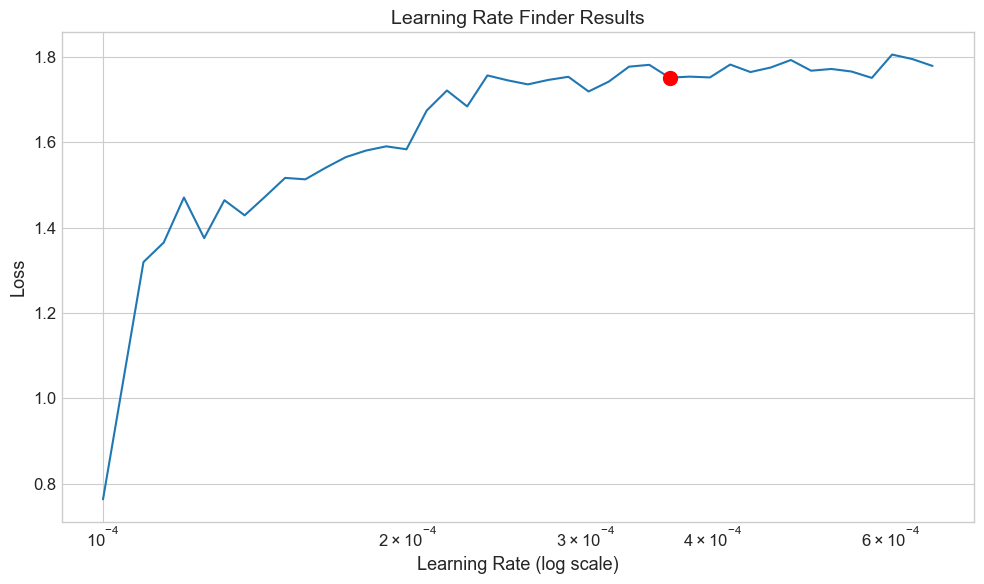

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00036308
Finding optimal learning rate...


Finding best initial lr:  39%|███▉      | 39/100 [00:00<00:00, 119.94it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 118.75it/s]
Learning rate set to 0.00022908676527677731
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_6e8accc7-bec0-45c6-aa9e-ff755ed6f5ae.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_6e8accc7-bec0-45c6-aa9e-ff755ed6f5ae.ckpt


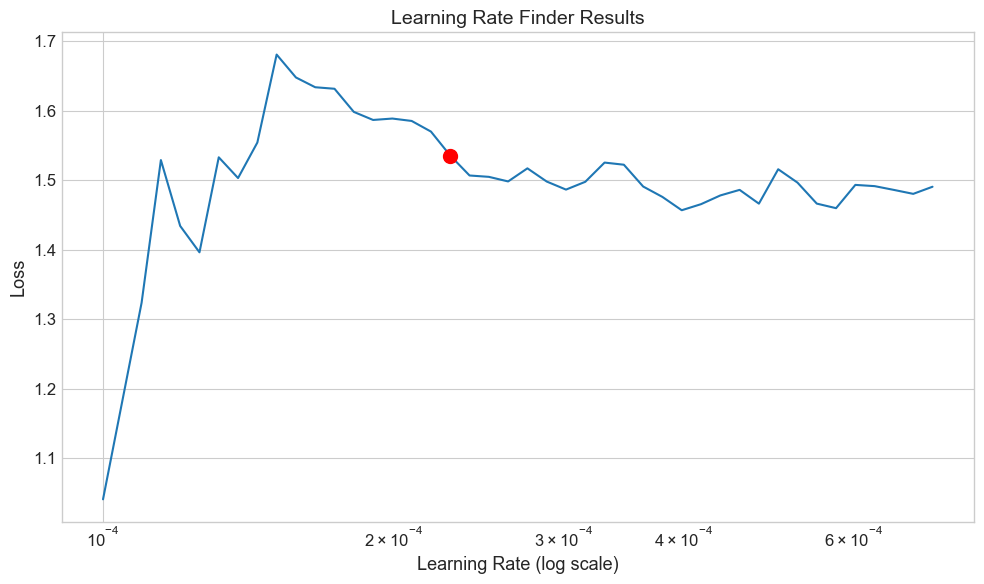

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00022909
  Finding learning rate for household_debt
Finding optimal learning rate...


Finding best initial lr:  28%|██▊       | 28/100 [00:00<00:00, 135.70it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 132.77it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_81738499-ba43-471e-a6d3-0823a27bd88a.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_81738499-ba43-471e-a6d3-0823a27bd88a.ckpt


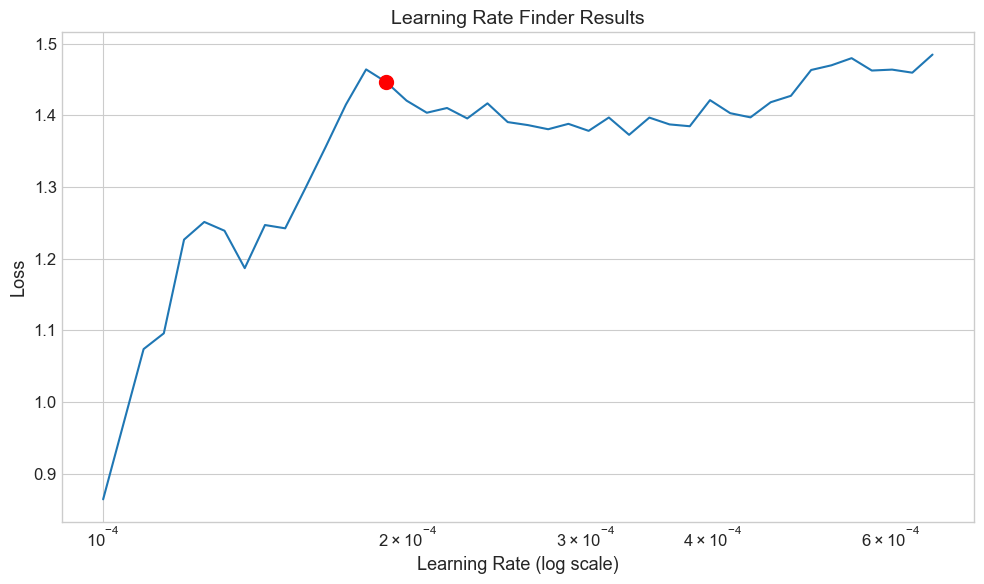

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00019055
Finding optimal learning rate...


Finding best initial lr:  30%|███       | 30/100 [00:00<00:00, 148.50it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 147.89it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_d519e7fb-8b84-4b18-9e60-3fa6479560ae.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_d519e7fb-8b84-4b18-9e60-3fa6479560ae.ckpt


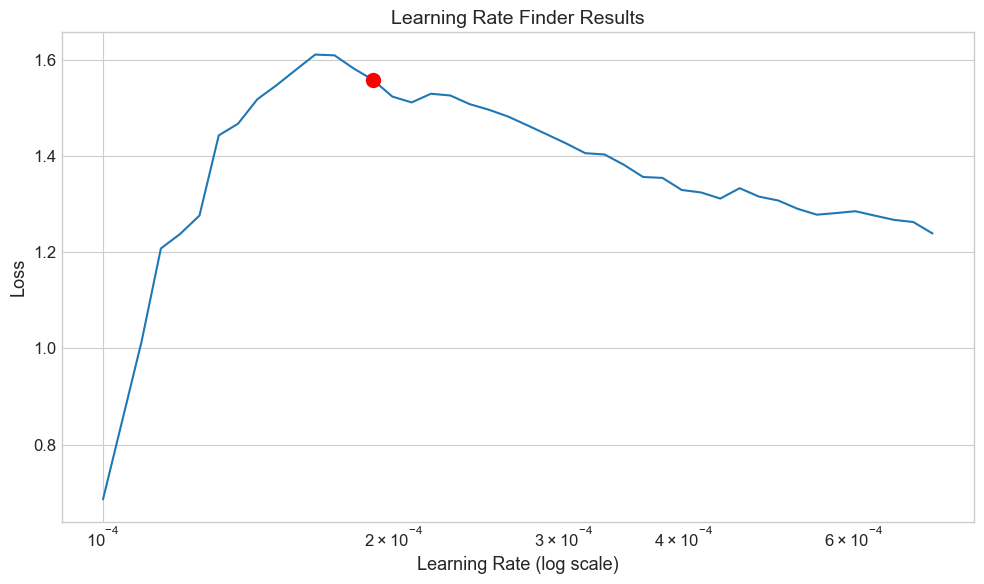

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00019055
  Finding learning rate for private_debt
Finding optimal learning rate...


Finding best initial lr:  30%|███       | 30/100 [00:00<00:00, 145.09it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 41 steps due to diverging loss.
Finding best initial lr:  41%|████      | 41/100 [00:00<00:00, 145.50it/s]
Learning rate set to 0.0002884031503126606
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_8c2bca9d-9b5e-4b24-aa4f-b10e6caaff25.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_8c2bca9d-9b5e-4b24-aa4f-b10e6caaff25.ckpt


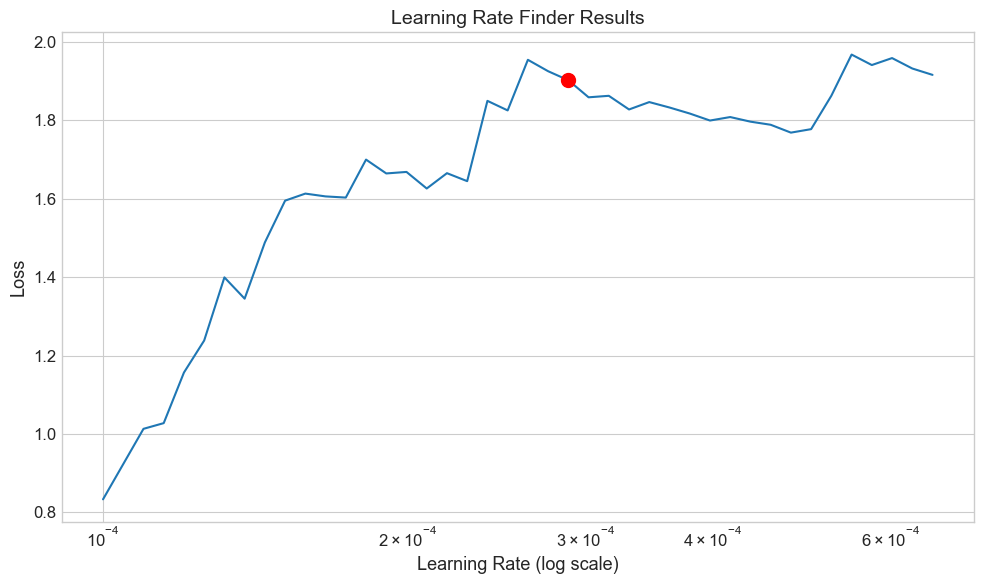

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00028840
Finding optimal learning rate...


Finding best initial lr:  31%|███       | 31/100 [00:00<00:00, 148.95it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 148.38it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_cca0127f-99f2-4470-8e65-84892ef3e96b.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_cca0127f-99f2-4470-8e65-84892ef3e96b.ckpt


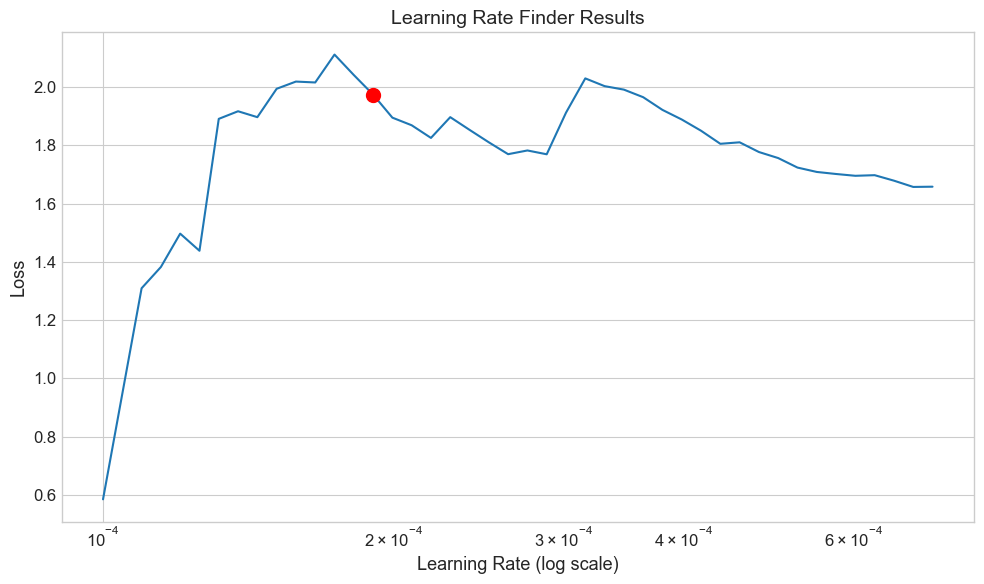

Seed set to 18
Seed set to 18
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than

Suggested learning rate: 0.00019055


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

  Computing metrics for log_GDP


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

  Computing metrics for household_debt


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

  Computing metrics for private_debt


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

Processing lag: 5
  Finding learning rate for log_GDP


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for lo

Finding optimal learning rate...


Finding best initial lr:  28%|██▊       | 28/100 [00:00<00:00, 138.24it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 40 steps due to diverging loss.
Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 136.38it/s]
Learning rate set to 0.00017378008287493755
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_6bfcbea9-a6de-42be-a7cb-15eb74a85587.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_6bfcbea9-a6de-42be-a7cb-15eb74a85587.ckpt


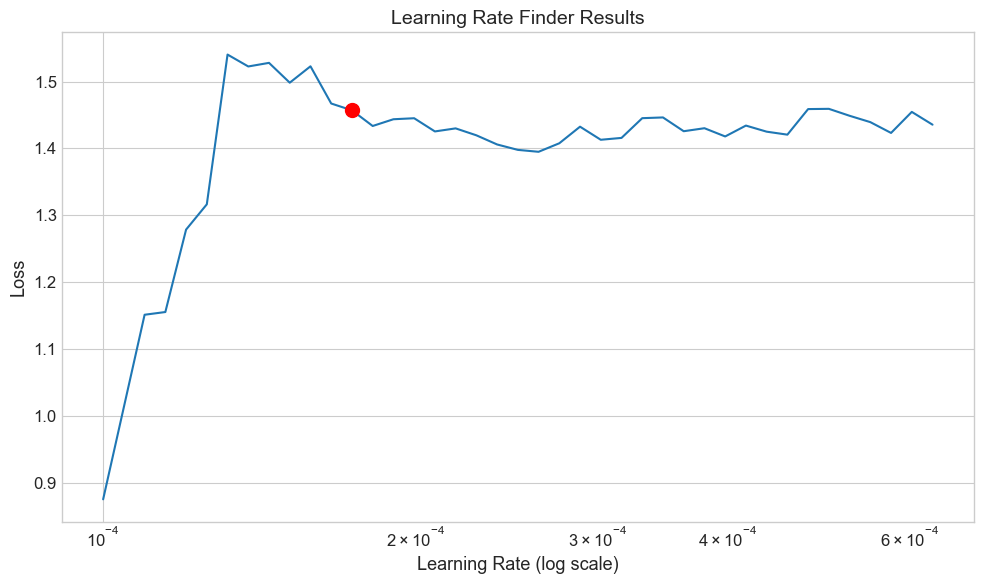

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00017378
Finding optimal learning rate...


Finding best initial lr:  29%|██▉       | 29/100 [00:00<00:00, 141.63it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 141.71it/s]
Learning rate set to 0.00022908676527677731
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_22ff8e80-6088-49ed-a5b2-ee45530a6222.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_22ff8e80-6088-49ed-a5b2-ee45530a6222.ckpt


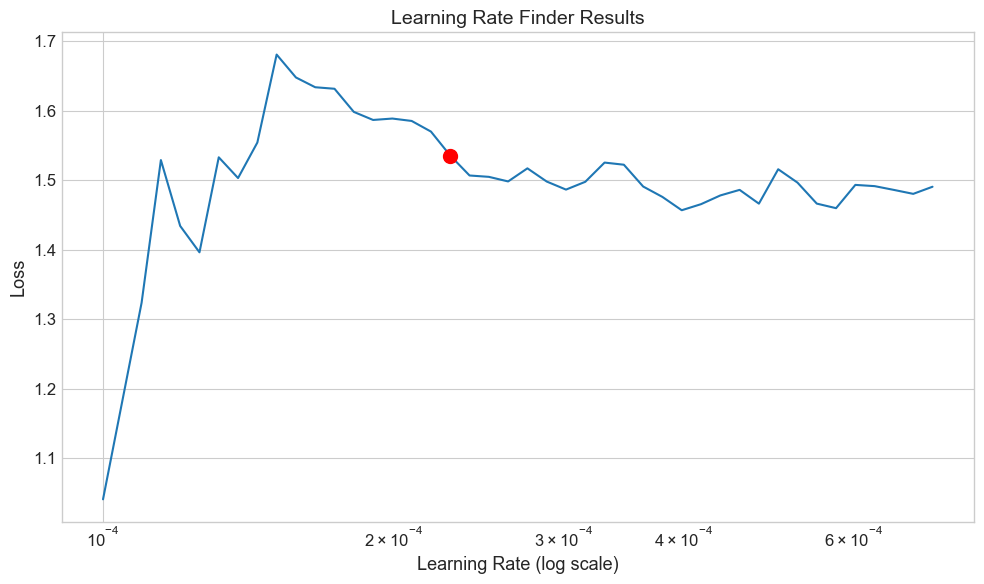

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00022909
  Finding learning rate for household_debt
Finding optimal learning rate...


Finding best initial lr:  31%|███       | 31/100 [00:00<00:00, 147.27it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 40 steps due to diverging loss.
Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 146.01it/s]
Learning rate set to 0.00018197008586099835
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_59083c08-689d-4dda-b720-bee805f7acd8.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_59083c08-689d-4dda-b720-bee805f7acd8.ckpt


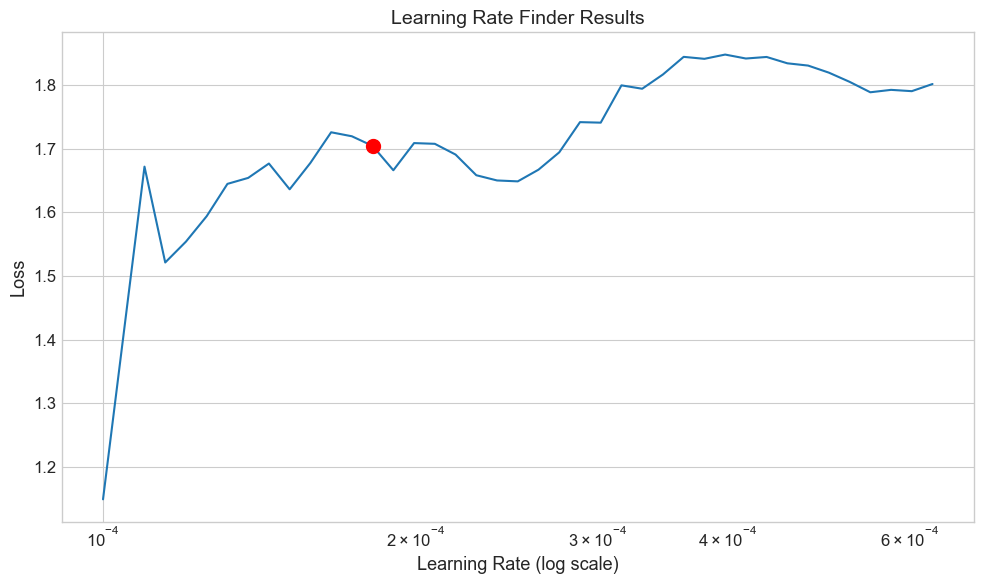

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00018197
Finding optimal learning rate...


Finding best initial lr:  30%|███       | 30/100 [00:00<00:00, 140.23it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 135.96it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_8ab3574d-b2de-4d21-bfea-fafb0d5bb700.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_8ab3574d-b2de-4d21-bfea-fafb0d5bb700.ckpt


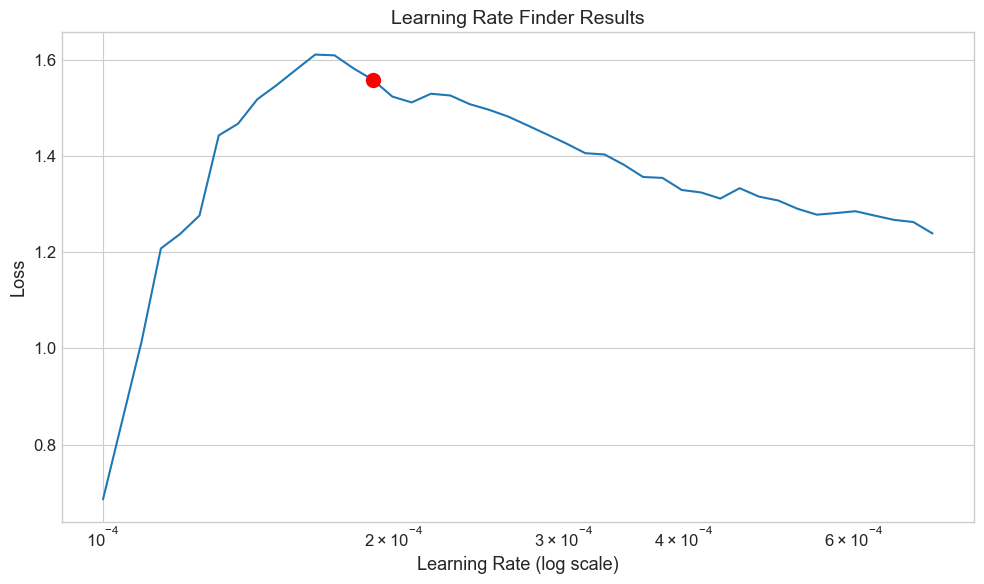

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00019055
  Finding learning rate for private_debt
Finding optimal learning rate...


Finding best initial lr:  30%|███       | 30/100 [00:00<00:00, 143.80it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 40 steps due to diverging loss.
Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 137.97it/s]
Learning rate set to 0.0005011872336272722
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_a55fb680-535c-4b9a-8d93-942ed90280d3.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_a55fb680-535c-4b9a-8d93-942ed90280d3.ckpt


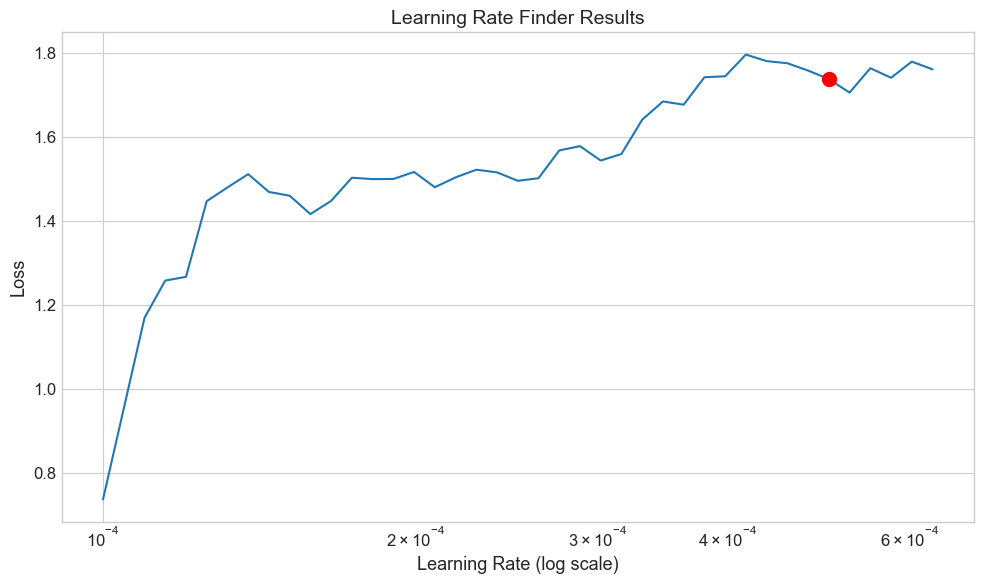

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00050119
Finding optimal learning rate...


Finding best initial lr:  31%|███       | 31/100 [00:00<00:00, 147.91it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 145.54it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_9470f736-6df9-45fb-9af7-3428345fd7de.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_9470f736-6df9-45fb-9af7-3428345fd7de.ckpt


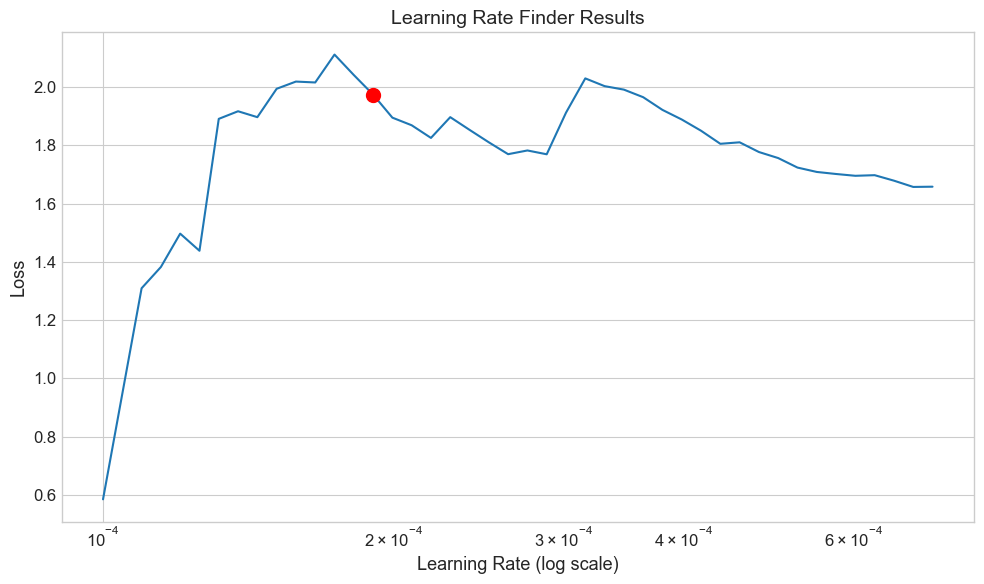

Seed set to 18
Seed set to 18
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than

Suggested learning rate: 0.00019055


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

  Computing metrics for log_GDP


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

  Computing metrics for household_debt


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

  Computing metrics for private_debt


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

Processing lag: 6
  Finding learning rate for log_GDP


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for lo

Finding optimal learning rate...


Finding best initial lr:  27%|██▋       | 27/100 [00:00<00:00, 131.93it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 40 steps due to diverging loss.
Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 129.61it/s]
Learning rate set to 0.00018197008586099835
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_a4bb9386-bafa-4539-85d7-7e475372c8c8.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_a4bb9386-bafa-4539-85d7-7e475372c8c8.ckpt


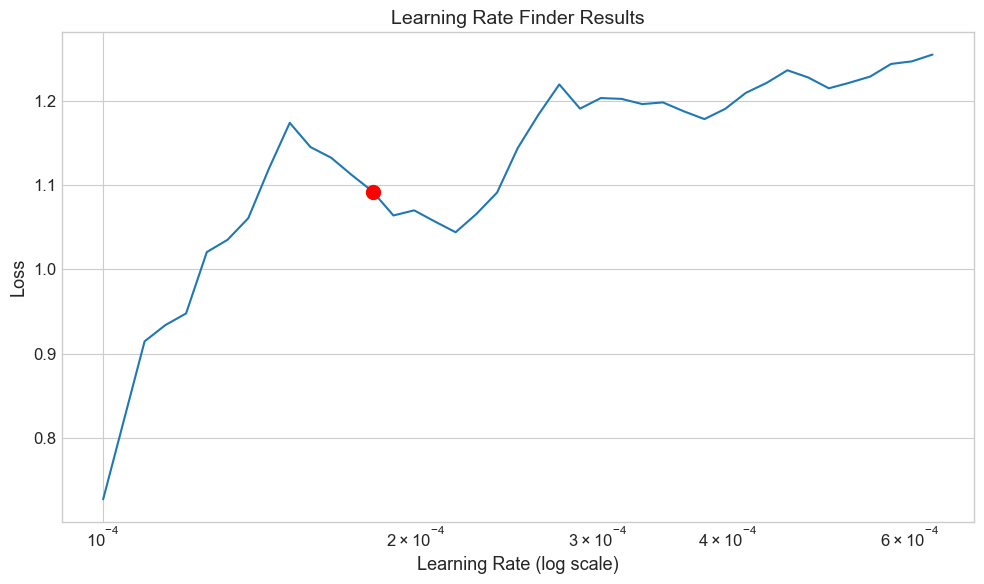

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00018197
Finding optimal learning rate...


Finding best initial lr:  42%|████▏     | 42/100 [00:00<00:00, 132.59it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 131.76it/s]
Learning rate set to 0.00022908676527677731
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_6707e98c-dcfa-4127-921d-48ce503de8c6.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_6707e98c-dcfa-4127-921d-48ce503de8c6.ckpt


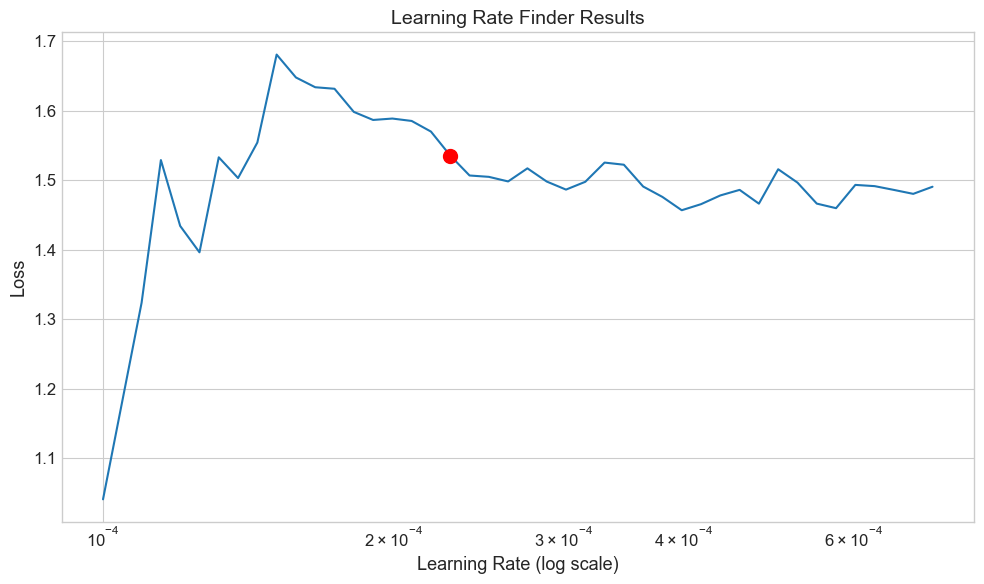

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00022909
  Finding learning rate for household_debt
Finding optimal learning rate...


Finding best initial lr:  30%|███       | 30/100 [00:00<00:00, 143.11it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 40 steps due to diverging loss.
Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 140.32it/s]
Learning rate set to 0.0003467368504525317
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_9a9a0f54-a707-4b8d-a8ca-60f9dce10256.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_9a9a0f54-a707-4b8d-a8ca-60f9dce10256.ckpt


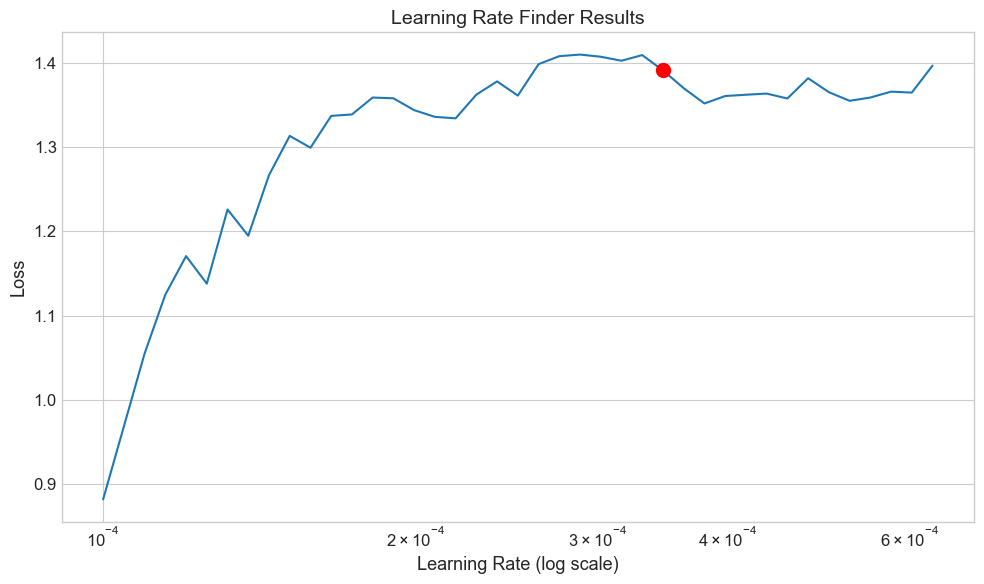

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00034674
Finding optimal learning rate...


Finding best initial lr:  29%|██▉       | 29/100 [00:00<00:00, 139.03it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 139.40it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_2dc26510-d8be-4384-84ca-621c23e561b1.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_2dc26510-d8be-4384-84ca-621c23e561b1.ckpt


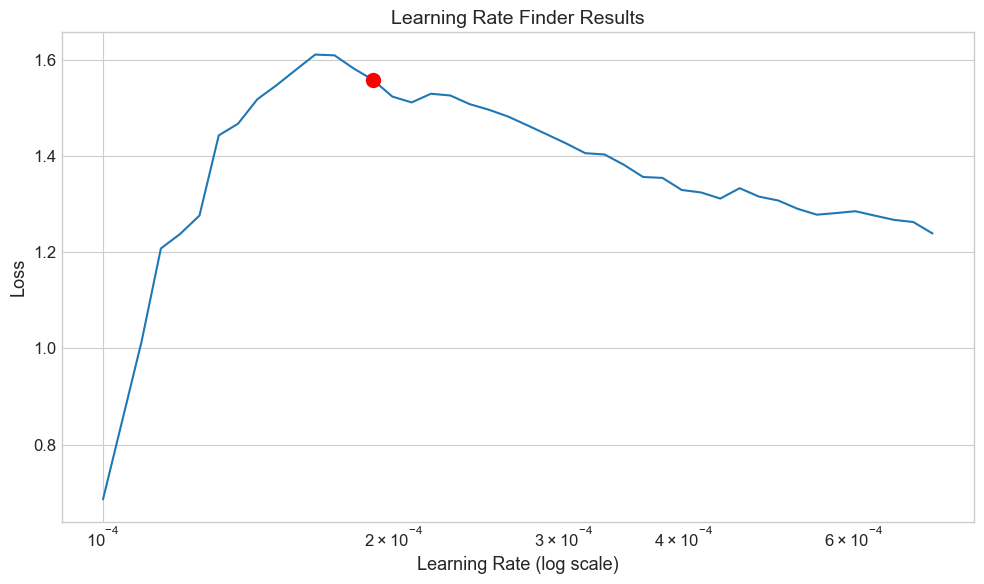

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00019055
  Finding learning rate for private_debt
Finding optimal learning rate...


Finding best initial lr:  31%|███       | 31/100 [00:00<00:00, 150.97it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 40 steps due to diverging loss.
Finding best initial lr:  40%|████      | 40/100 [00:00<00:00, 149.99it/s]
Learning rate set to 0.00023988329190194904
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_6433aa4d-8703-42d2-a5ce-d4a32212d710.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_6433aa4d-8703-42d2-a5ce-d4a32212d710.ckpt


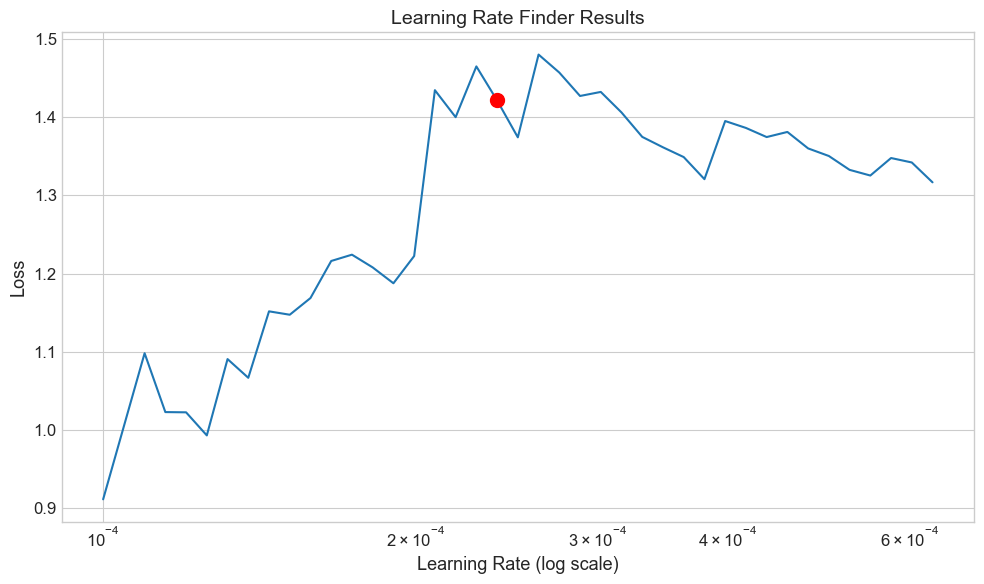

Seed set to 18
Seed set to 18
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps

Suggested learning rate: 0.00023988
Finding optimal learning rate...


Finding best initial lr:  31%|███       | 31/100 [00:00<00:00, 147.81it/s]`Trainer.fit` stopped: `max_epochs=1` reached.
LR finder stopped early after 43 steps due to diverging loss.
Finding best initial lr:  43%|████▎     | 43/100 [00:00<00:00, 148.12it/s]
Learning rate set to 0.00019054607179632473
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_ce88af8f-168d-4f7b-940f-2e98a1e9d600.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_ce88af8f-168d-4f7b-940f-2e98a1e9d600.ckpt


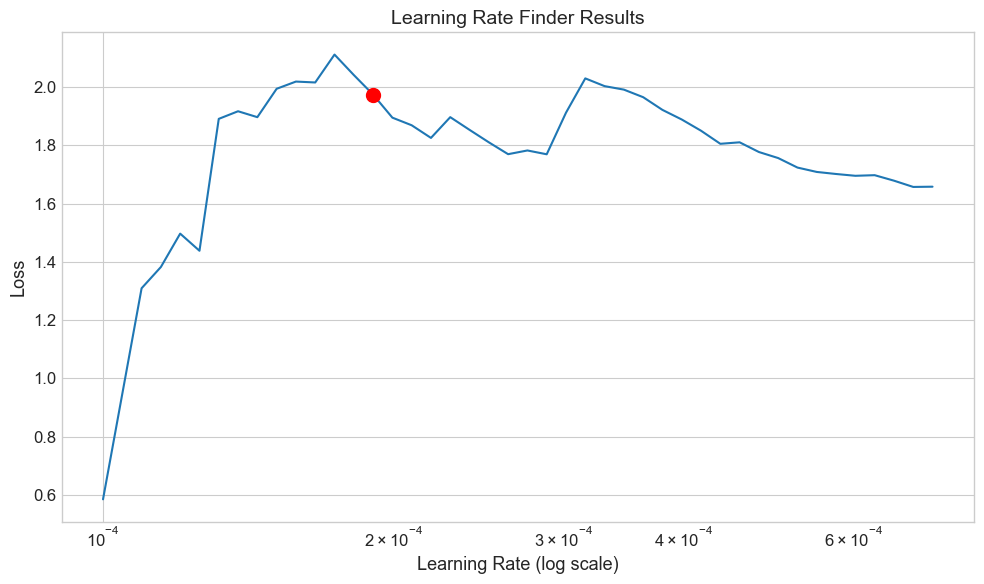

Seed set to 18
Seed set to 18
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).to(device)
/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/lstm.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than

Suggested learning rate: 0.00019055


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pytorch

  Computing metrics for log_GDP


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

  Computing metrics for household_debt


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t

  Computing metrics for private_debt


Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set to 18
Seed set t


Error metrics for log_GDP:
  no_window_mse no_window_rmse no_window_mae window_mse window_rmse window_mae
1      0.000066       0.008117      0.005116   0.000066    0.008117   0.005116
2      0.000065       0.008087      0.005062   0.000065    0.008092   0.005091
3      0.000065       0.008067      0.005066   0.000065    0.008091    0.00509
4      0.000064       0.008005      0.005046   0.000066    0.008094   0.005092
5      0.000066       0.008099      0.005133   0.000066    0.008099   0.005096
6      0.000063       0.007955      0.005048   0.000065    0.008067   0.005074

Error metrics for household_debt:
  no_window_mse no_window_rmse no_window_mae window_mse window_rmse window_mae
1      0.505288       0.710836      0.535556   0.505288    0.710836   0.535556
2      0.515102       0.717706      0.550245   0.518822    0.720293   0.545597
3      0.493446       0.702457      0.533384   0.495066    0.703609   0.526783
4      0.399971       0.632433      0.459026     0.5006    0.707531 

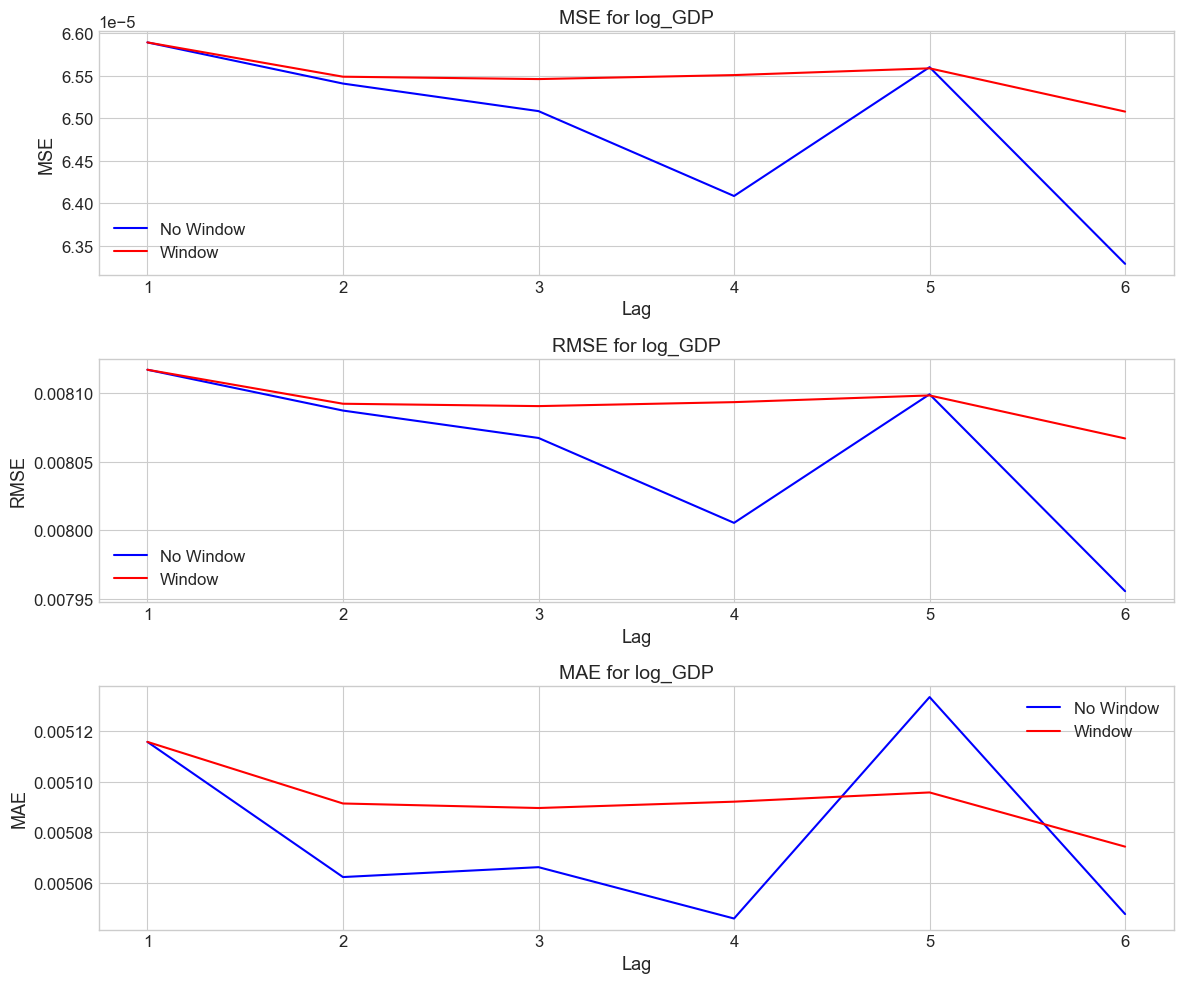

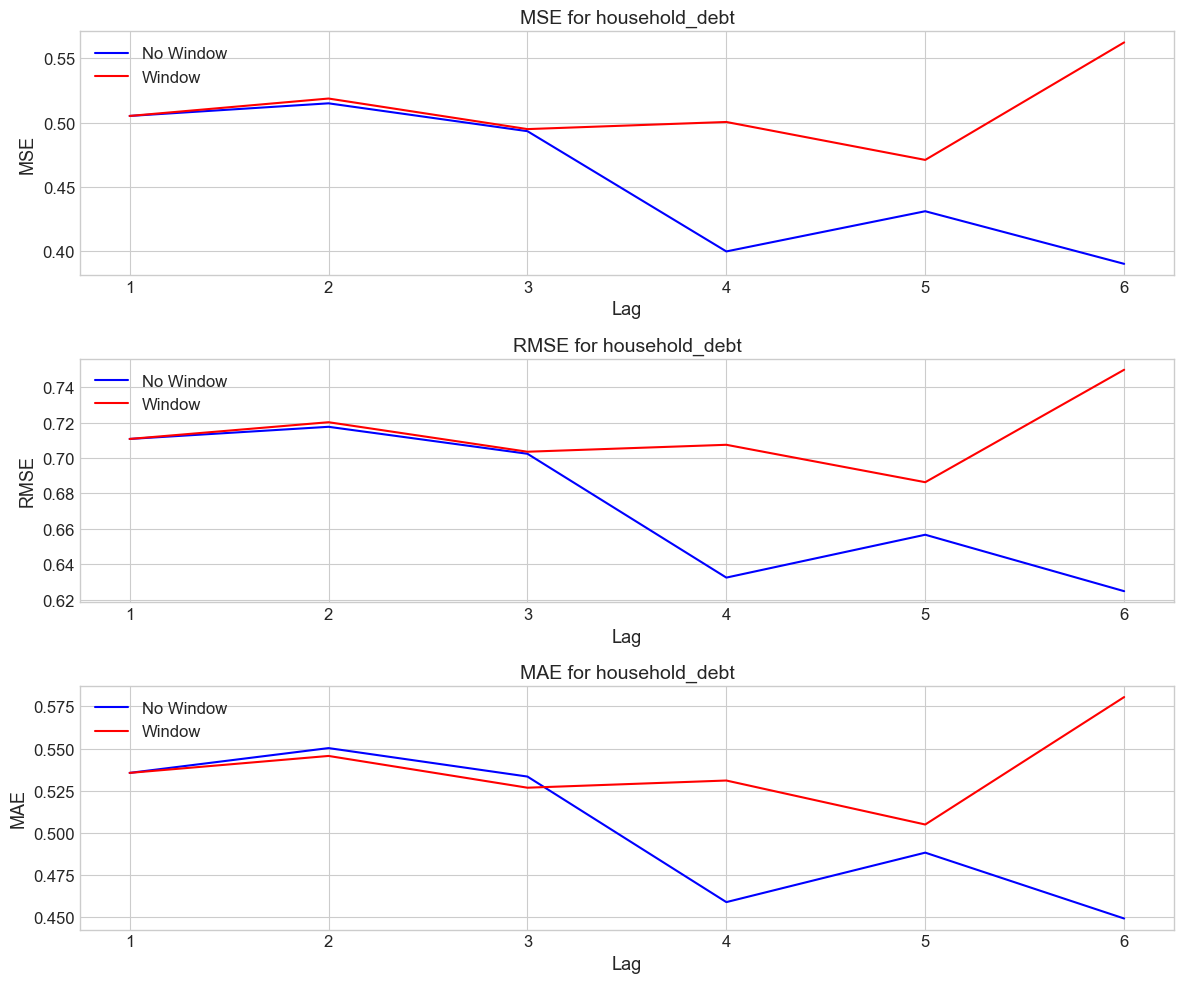

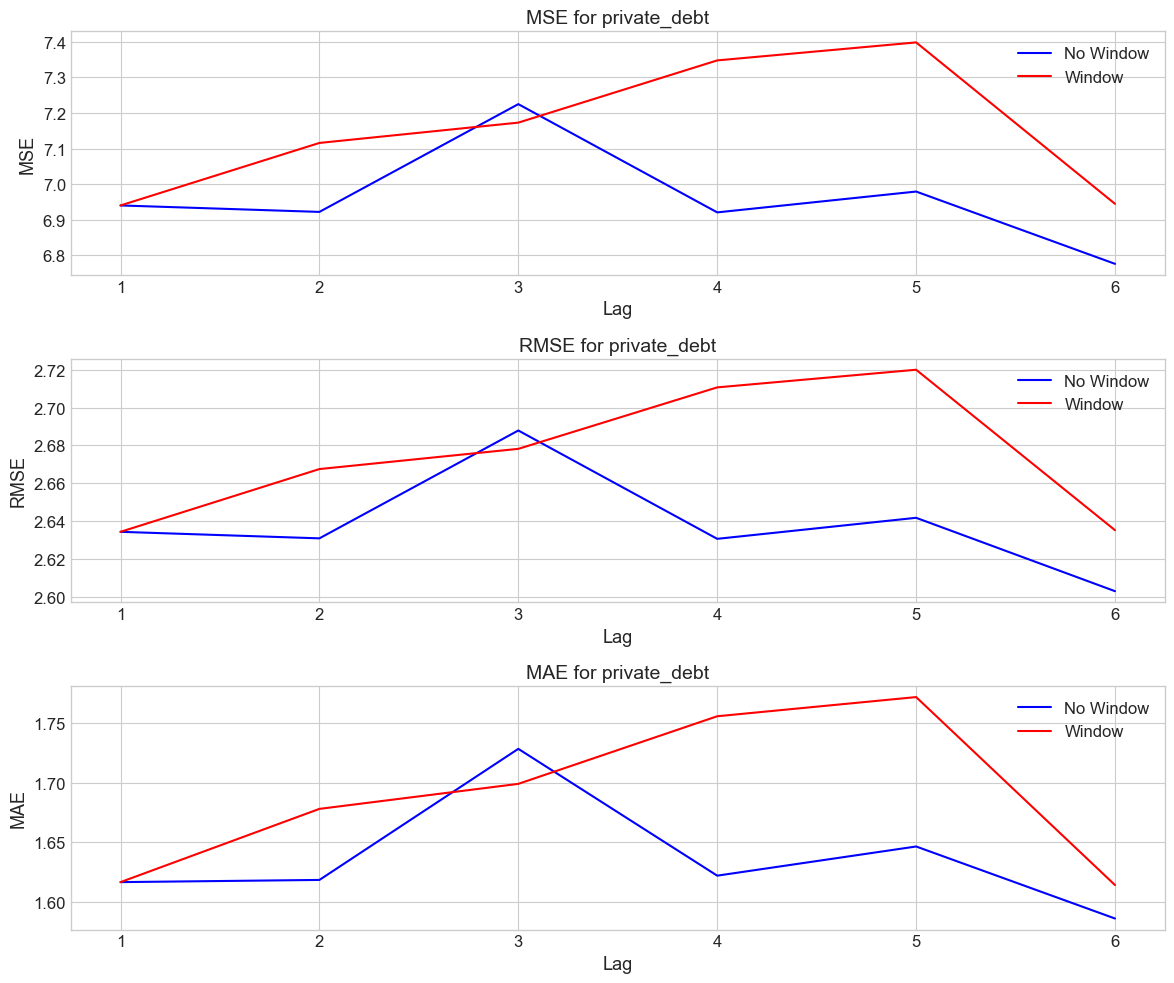

In [ ]:
MIN_LAG = 1
MAX_LAG = 6 
lag_range = range(MIN_LAG, MAX_LAG + 1)

results = {
    'log_GDP': {},
    'household_debt': {},
    'private_debt': {}
}

lstm_df_window = lstm.create_lstm_data(final_detrend, 1)
lstm_train_window, lstm_val_window, lstm_test_window= lstm.train_val_test_split(lstm_df_window)
inputs_window = lstm.get_lstm_input(final_detrend, 1)

# Loop through each lag
for lag in lag_range:
    print(f"Processing lag: {lag}")
    
    lstm_df = lstm.create_lstm_data(final_detrend, lag)
    lstm_train, lstm_val, lstm_test= lstm.train_val_test_split(lstm_df)

    
    # Define input features for both approaches
    inputs = [col for col in lstm_df.columns if col not in variables]
    inputs_window = [col for col in lstm_df_window.columns if col not in variables]
    
    # Initialize parameter dictionaries for this lag
    param_dict_no_window = {}
    param_dict_window = {}
    
    # Find optimal learning rates for each variable
    min_lr = 0.0001
    max_lr = 0.01
    
    for variable in variables:
        print(f"  Finding learning rate for {variable}")
        
        # Find best learning rate for no-window approach
        best_lr = lstm.find_learning_rate(lstm_df, inputs, f'{variable}', min_lr=min_lr, max_lr=max_lr)
        param_dict_no_window[variable] = {'learning_rate': best_lr, 'epochs': 500}
        
        # Find best learning rate for window approach
        best_lr_window = lstm.find_learning_rate(lstm_df_window, inputs_window, f'{variable}', 
                                               min_lr=min_lr, max_lr=max_lr)
        param_dict_window[variable] = {'learning_rate': best_lr_window, 'epochs': 500}
    
    # Train models with the optimal parameters
    model_scaler_dict_no_window = deepvar.get_model_and_scaler_no_window(
        lstm_df, variables, inputs, param_dict_no_window)
    model_scaler_dict_window = deepvar.get_model_and_scaler_window(
        lstm_df_window, variables, inputs_window, param_dict_window, lag)
    
    # Calculate error metrics for each variable
    for variable in variables:
        print(f"  Computing metrics for {variable}")
        
        # For no-window approach
        no_window_metrics = deepvar.test_errors(
            lstm_df, lstm_test, variable, model_scaler_dict_no_window, variables, lag)
        
        # For window approach
        # Note: For the windowed version, the effective lag is always 1 because the window has the length of the lag
        window_metrics = deepvar.test_errors(
            lstm_df_window, lstm_test_window, variable, model_scaler_dict_window, variables, 1)
        
        # Store results
        if lag not in results[variable]:
            results[variable][lag] = {
                'no_window': no_window_metrics,
                'window': window_metrics
            }

def create_error_df(variable_results):
    index = list(variable_results.keys())  # lags as index
    columns = ['no_window_mse', 'no_window_rmse', 'no_window_mae', 
               'window_mse', 'window_rmse', 'window_mae']
    df = pd.DataFrame(index=index, columns=columns)
    
    # Fill the DataFrame with values
    for lag, metrics in variable_results.items():
        df.loc[lag, 'no_window_mse'] = metrics['no_window'][0]
        df.loc[lag, 'no_window_rmse'] = metrics['no_window'][1]
        df.loc[lag, 'no_window_mae'] = metrics['no_window'][2]
        df.loc[lag, 'window_mse'] = metrics['window'][0]
        df.loc[lag, 'window_rmse'] = metrics['window'][1]
        df.loc[lag, 'window_mae'] = metrics['window'][2]
    
    return df

# generate and save error for each variable
error_dfs = {}
for variable in variables:
    error_dfs[variable] = create_error_df(results[variable])
    print(f"\nError metrics for {variable}:")
    print(error_dfs[variable])
    
    error_dfs[variable].to_csv(f"{variable}windowcomp_error_metrics.csv")



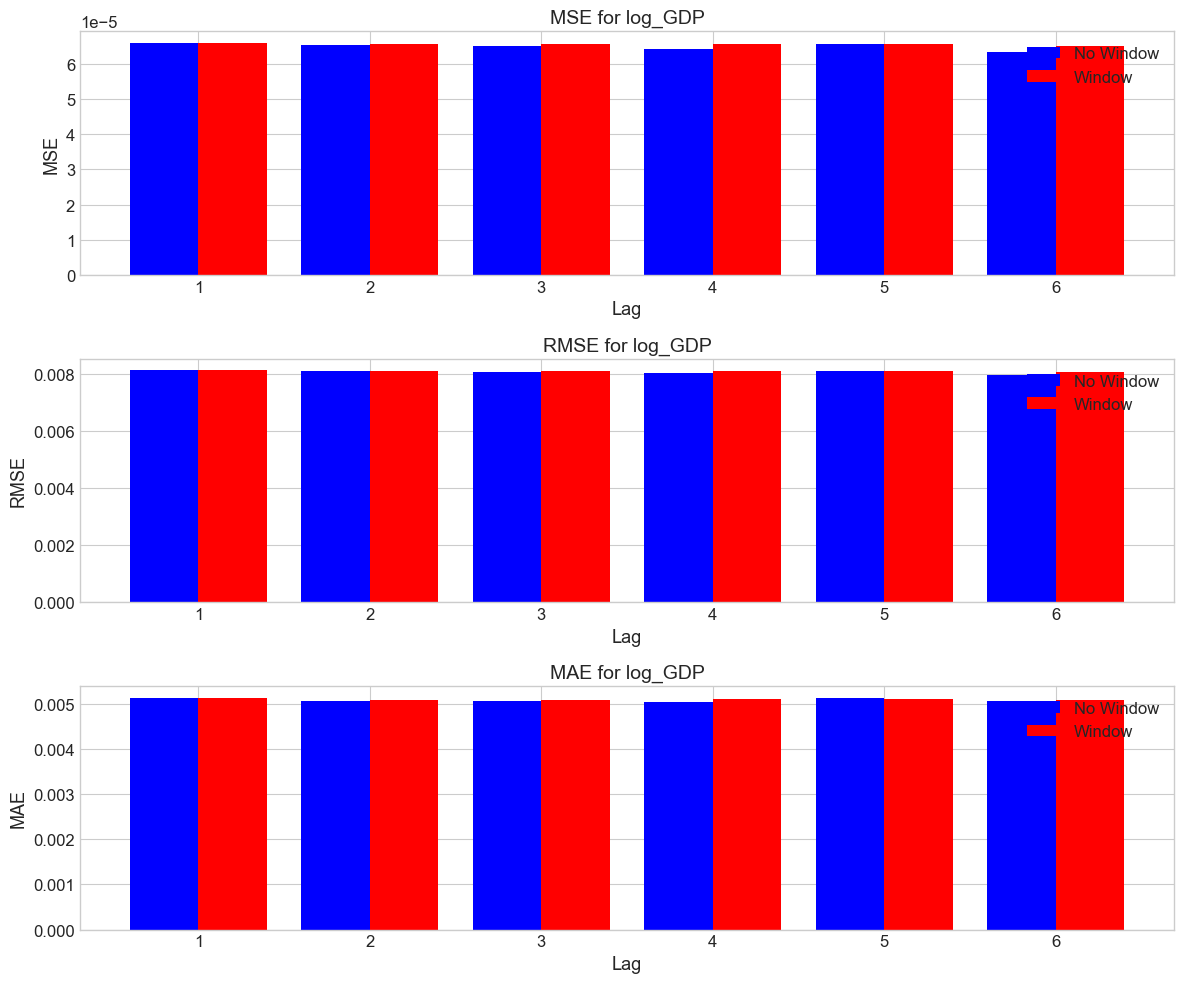

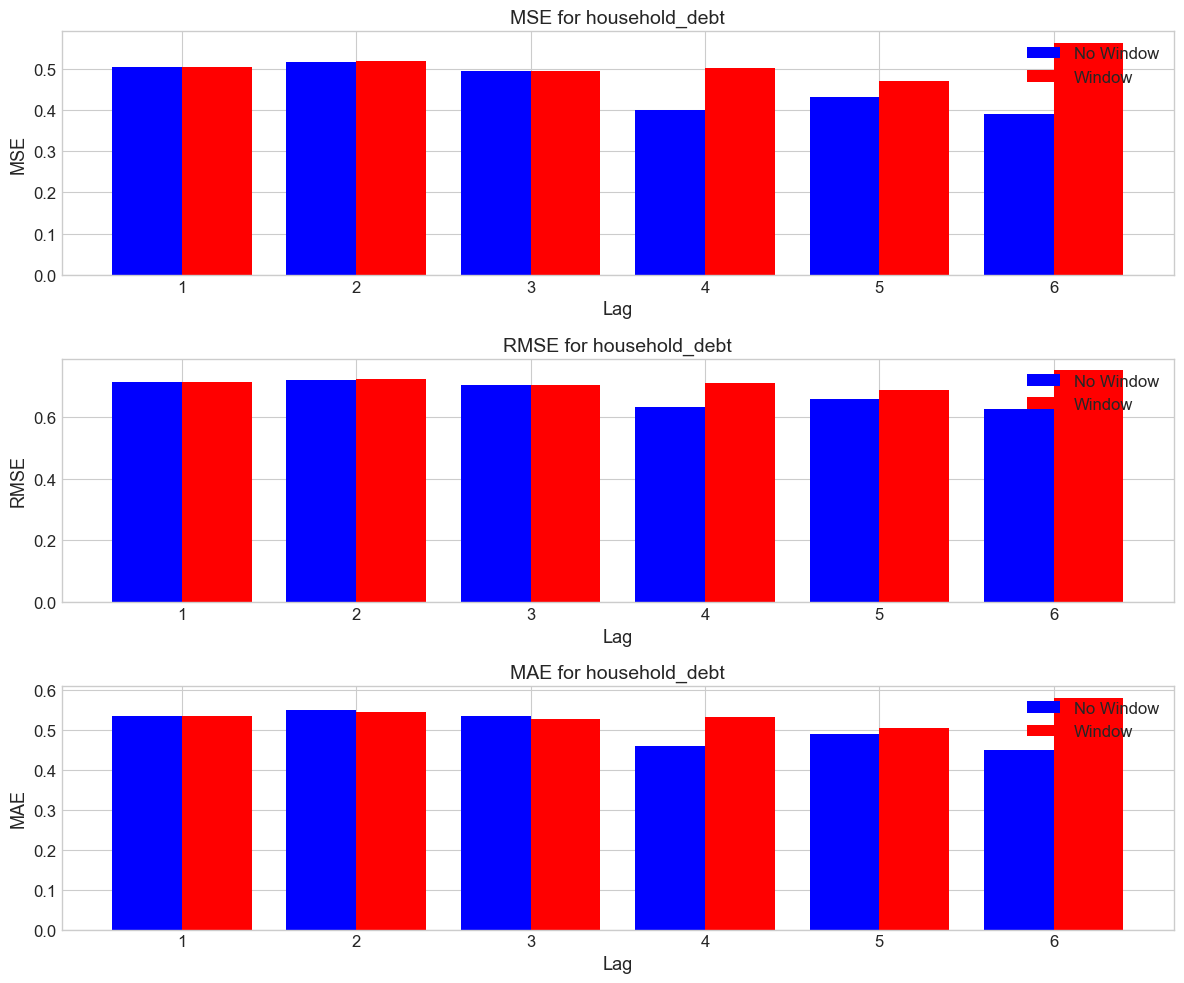

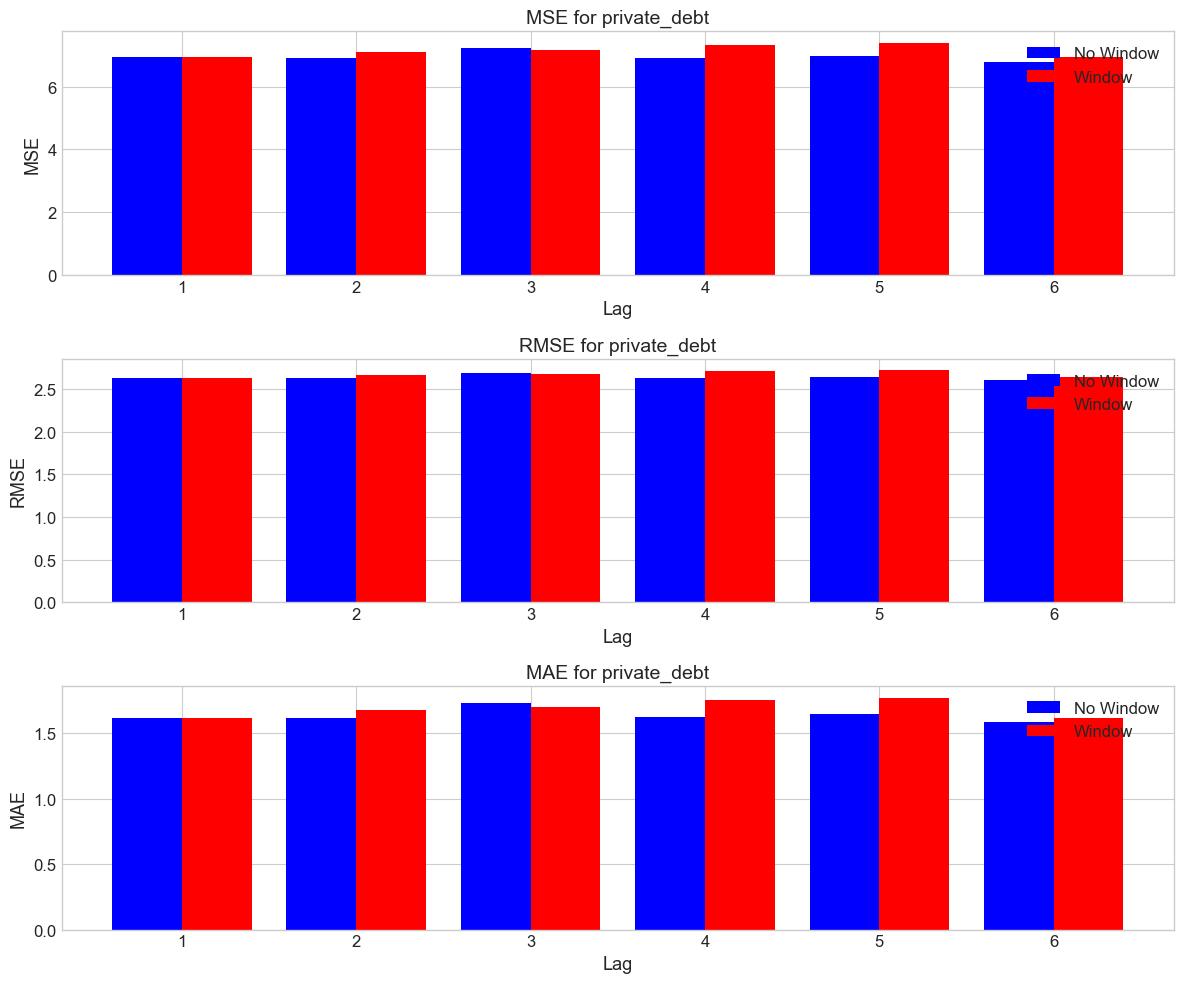

In [ ]:
def plot_error_metrics(variable, error_df):
    plt.figure(figsize=(12, 10))
    
    # Plot MSE
    plt.subplot(3, 1, 1)
    plt.bar(error_df.index - 0.2, error_df['no_window_mse'], width=0.4, label='No Window', color='b')
    plt.bar(error_df.index + 0.2, error_df['window_mse'], width=0.4, label='Window', color='r')
    plt.title(f'MSE for {variable}')
    plt.xlabel('Lag')
    plt.ylabel('MSE')
    plt.legend()
    
    # Plot RMSE
    plt.subplot(3, 1, 2)
    plt.bar(error_df.index - 0.2, error_df['no_window_rmse'], width=0.4, label='No Window', color='b')
    plt.bar(error_df.index + 0.2, error_df['window_rmse'], width=0.4, label='Window', color='r')
    plt.title(f'RMSE for {variable}')
    plt.xlabel('Lag')
    plt.ylabel('RMSE')
    plt.legend()
    
    # Plot MAE
    plt.subplot(3, 1, 3)
    plt.bar(error_df.index - 0.2, error_df['no_window_mae'], width=0.4, label='No Window', color='b')
    plt.bar(error_df.index + 0.2, error_df['window_mae'], width=0.4, label='Window', color='r')
    plt.title(f'MAE for {variable}')
    plt.xlabel('Lag')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{variable}_error_metrics.png")
    plt.show()

for variable in variables:
    plot_error_metrics(variable, error_dfs[variable])



In [ ]:
balanced_data = pd.read_csv('./balanced_data.csv')
balanced_data = balanced_data[['country', 'quarter', 'l_GDP_dif', 'hd_dif', 'pd_dif']]
balanced_data = balanced_data.dropna()

balanced_data


,country,quarter,l_GDP_dif,hd_dif,pd_dif
0,Argentina,2008q2,0.003586,0.100000,-1.299999
1,Argentina,2008q3,0.007642,-0.100000,-0.200001
2,Argentina,2008q4,-0.046987,0.200000,0.100000
3,Argentina,2009q1,-0.036652,-0.100000,0.500000
4,Argentina,2009q2,-0.024878,0.000000,0.200001
...,...,...,...,...,...
2413,United States,2022q3,0.006564,-0.299995,-1.200005
2414,United States,2022q4,0.006334,-0.500000,-0.799995
2415,United States,2023q1,0.005548,-1.200005,-0.400002
2416,United States,2023q2,0.005098,-0.399994,-1.000000


In [44]:
lstm_test_window.size

4956